In [12]:
# pip install geopandas shapely
# pip install geopy
# !pip install pmdarima
# !conda install -c conda-forge scikit-surprise -y
# !pip install pyshp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 535.2 kB/s eta 0:00:00 0:00:01


In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
import xml.etree.ElementTree as ET
import urllib.request as req
import json 
import re
import matplotlib.pyplot as plt
import math
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import Point
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib
from sklearn.pipeline import Pipeline

# Info

In [92]:
info_coord = pd.read_pickle('各里中心點經緯度.pkl')
info_coord.rename(columns={'addr_city':'縣市', '緯度':'lon', '經度':'lat'}, inplace=True)
info_coord['縣市'] = info_coord['縣市'].apply(lambda x: re.sub('台','臺',x))
info_coord

,縣市,addr_district,addr_village,lat,lon
0,臺中市,北區,賴旺里,24.172038,120.673495
1,臺中市,北區,五常里,24.154454,120.681675
2,臺中市,北屯區,北京里,24.162347,120.692539
3,臺中市,南區,福平里,24.127956,120.663696
4,臺中市,南屯區,大業里,24.152642,120.651376
5,臺中市,大甲區,文武里,24.352075,120.622707
6,臺中市,大里區,新里里,24.101547,120.675389
7,臺中市,大雅區,大楓里,24.228441,120.667409
8,臺中市,烏日區,榮泉里,24.113192,120.592617
9,臺中市,西屯區,西平里,24.182988,120.646553


In [131]:
info = pd.read_excel('restaurant_info.xlsx')
info.head()

,blur_restaurant_uuid,addr_city,addr_district,addr_village,2023-10-07,2023-10-08,2023-10-09,2023-10-10,2023-10-11,2023-10-12,2023-10-13
0,r71ee64,台中市,北區,賴旺里,06:30-15:00,06:30-15:00,07:30-14:30,NaN,06:00-14:00,06:00-14:00,06:00-14:30
1,rec62b3,台中市,北區,五常里,05:30-13:30,05:30-13:00,05:30-13:30,05:30-13:30,05:30-13:00,07:00-13:30,06:00-13:30
2,rfa1ab3,台中市,北屯區,北京里,08:00-15:00,07:30-16:00,08:00-16:00,08:00-15:30,NaN,08:30-15:00,08:00-13:30
3,r4ea226,台中市,南區,福平里,05:30-13:30,05:30-13:30,NaN,05:30-13:30,05:30-13:30,NaN,05:30-14:30
4,r3d1075,台中市,南屯區,大業里,06:00-14:30,06:30-14:30,NaN,06:30-14:30,06:30-14:00,06:30-15:00,06:30-14:00


In [161]:
info[info['addr_city']=='新北市']['addr_village'].tolist()

['華貴里', '新民里', '光復里', '文化里', '漢生里']

In [77]:
info[['addr_city']].value_counts()

addr_city
台中市          12
桃園市          10
台北市           8
新北市           5
高雄市           3
台南市           2
Name: count, dtype: int64

In [132]:
info['addr_city'] = info['addr_city'].apply(lambda x: re.sub('台','臺',x))
info[['addr_city']].value_counts()

addr_city
臺中市          12
桃園市          10
臺北市           8
新北市           5
高雄市           3
臺南市           2
Name: count, dtype: int64

In [96]:
info[['addr_city','addr_district']].value_counts()

addr_city  addr_district
新北市        板橋區              5
臺北市        松山區              3
臺中市        西屯區              3
高雄市        三民區              2
桃園市        桃園區              2
           蘆竹區              2
           龍潭區              2
臺中市        北區               2
臺北市        大安區              2
           士林區              2
臺中市        烏日區              1
臺南市        歸仁區              1
           北區               1
臺北市        大同區              1
臺中市        大甲區              1
           大雅區              1
           大里區              1
桃園市        中壢區              1
臺中市        南屯區              1
           南區               1
           北屯區              1
桃園市        龜山區              1
           觀音區              1
           平鎮區              1
高雄市        鳳山區              1
Name: count, dtype: int64

In [214]:
len(info[['addr_city','addr_district']].drop_duplicates())

25

In [7]:
sum(info[['addr_city','addr_district','addr_village']].value_counts()!=1)

0

In [164]:
restaurant_pkl = ['pkl_data/'+x+'.pkl' for x in info['blur_restaurant_uuid']]
restaurant_pkl[:3]

['pkl_data/r71ee64.pkl', 'pkl_data/rec62b3.pkl', 'pkl_data/rfa1ab3.pkl']

In [165]:
restaurant_js = ['restaurant_data/'+x+'.json' for x in info['blur_restaurant_uuid']]
restaurant_js[:3]

['restaurant_data/r71ee64.json',
 'restaurant_data/rec62b3.json',
 'restaurant_data/rfa1ab3.json']

# 交易資料

從2021.07開始，才是所有店家都有資料。

In [15]:
js = pd.read_json('restaurant_data/r3c8001.json')
js.iloc[0]

blur_restaurant_uuid                                                     r3c8001
blur_invoice_id                         02aafc629ceb4883c39d74755cc1f82ca89dc9a8
invoice_unix_timestamp                                           1606352622.6474
invoice_total_amount                                                         133
invoice_discount_amount                                                        0
customer_group_people                                                          1
customer_group_table_name                                                     A6
customer_group_service_type                                               indoor
platform_type                                                               None
order_type                                                                  None
blur_customer_order            [{'blur_category': '[535e]套餐', 'blur_name': '[...
Name: 0, dtype: object

In [16]:
js.iloc[0,10]

[{'blur_category': '[535e]套餐',
  'blur_name': '[ed65]*元套餐',
  'blur_original_price': 54,
  'blur_quantity': 1,
  'blur_menu_item_tag': [],
  'blur_combo_item_category': ['[797c]副食', '[f2f7]飲料']},
 {'blur_category': '[3b73]漢堡',
  'blur_name': '[d8d2]招牌漢堡 豬',
  'blur_original_price': 79,
  'blur_quantity': 1,
  'blur_menu_item_tag': [],
  'blur_combo_item_category': []}]

In [8]:
# df = pd.read_json('restaurant_data/r3c8001.json')
df = pd.read_pickle('pkl_data/r3c8001.pkl')
df.head()

,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_local_timestamp,invoice_date,invoice_total_amount,customer_group_people,customer_group_table_name,customer_group_service_type,order_type,blur_category,blur_name,blur_original_price,blur_quantity,blur_menu_item_tag,blur_combo_item_category
0,r3c8001,02aafc629ceb4883c39d74755cc1f82ca89dc9a8,1.606353e+09,2020-11-26 09:03:42,2020-11-26,133,1,A6,indoor,None,[535e]套餐,[ed65]*元套餐,54,1,[],"[[797c]副食, [f2f7]飲料]"
1,r3c8001,02aafc629ceb4883c39d74755cc1f82ca89dc9a8,1.606353e+09,2020-11-26 09:03:42,2020-11-26,133,1,A6,indoor,None,[3b73]漢堡,[d8d2]招牌漢堡 豬,79,1,[],[]
2,r3c8001,f88a8d21b3dddddc3f8ceff7c11216031ac174f3,1.606355e+09,2020-11-26 09:50:36,2020-11-26,40,1,A7,indoor,None,[3f15]三明治,[5384]起司,40,1,[],[]
3,r3c8001,3179016a825164d56b0db2a8a346dbf8ced83c35,1.606358e+09,2020-11-26 10:29:10,2020-11-26,149,2,A7,indoor,None,[1d36]飲料,[a617]鮮奶茶,45,1,[],[]
4,r3c8001,3179016a825164d56b0db2a8a346dbf8ced83c35,1.606358e+09,2020-11-26 10:29:10,2020-11-26,149,2,A7,indoor,None,[23f6]蛋餅,[7b47]原味蛋餅,25,1,[],[]


In [29]:
df['invoice_date'].drop_duplicates().sort_values()

0         2020-05-26
531       2020-05-27
1214      2020-05-28
1814      2020-05-29
2438      2020-05-30
             ...    
243069    2023-10-02
243241    2023-10-03
243415    2023-10-04
145336    2023-10-05
243598    2023-10-06
Name: invoice_date, Length: 1229, dtype: object

In [167]:
# 一個餐點一筆觀測值
df = pd.DataFrame()
for file in restaurant_pkl:
    df = pd.concat([df, pd.read_pickle(file)], axis=0)
print(df.shape)
df.head()
# 1m 22.4s

(10847803, 16)


,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_local_timestamp,invoice_date,invoice_total_amount,customer_group_people,customer_group_table_name,customer_group_service_type,order_type,blur_category,blur_name,blur_original_price,blur_quantity,blur_menu_item_tag,blur_combo_item_category
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f5b2]飲品 咖啡,[ae6e]紅茶豆漿,20.0,1.0,[[f94f]1/3],[]
1,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[6081]果醬,[cc1f]芋泥肉鬆法土,55.0,1.0,[],[]
2,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f5b2]飲品 咖啡,[ac5a]奶茶,25.0,1.0,"[[f53d]1/2, [abca]中溫]",[]
3,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[8dd2]特酥蛋餅,[2652]大總匯,75.0,1.0,[],[]
4,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f0b9]點心,[e295]小炸物 雞薯條,49.0,1.0,[],[]


In [ ]:
# 一個訂單一個觀測值
df_trans = pd.DataFrame()
for file in restaurant_js:
    df_trans = pd.concat([df_trans, pd.read_json(file)], axis=0)
print(df_trans.shape)
df_trans.head()
# 7m 16.1s

In [28]:
df_trans = df_trans.merge(info[['blur_restaurant_uuid','addr_city','addr_district','addr_village']], how='left', on=['blur_restaurant_uuid'])
df_trans.head()
# 13.3s

,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_total_amount,invoice_discount_amount,customer_group_people,customer_group_table_name,customer_group_service_type,platform_type,order_type,blur_customer_order,addr_city,addr_district,addr_village
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,224.0,0,2,A21,indoor,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里
1,r71ee64,dfe10cd047325266f402f438c33c617b242b5e0a,1.612570e+09,222.0,0,2,A7,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里
2,r71ee64,da8ca403ad20828e101843718c40c6e2ecb5ee71,1.612571e+09,134.0,0,1,takeOut,takeout,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里
3,r71ee64,cde4655c4536e044495f0e797cecc97c0775baa6,1.612571e+09,283.0,0,3,A10,indoor,None,None,"[{'blur_category': '[937c]', 'blur_name': '[c8...",台中市,北區,賴旺里
4,r71ee64,ffc183674c785d0acc27ec6bd4c7dad10d1f0c75,1.612571e+09,224.0,0,3,A6,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里


In [32]:
date_time = datetime.fromtimestamp(df_trans['invoice_unix_timestamp'][0])
print(date_time)
date_time.strftime('%Y-%m-%d %H:%M:%S')

2021-02-06 08:03:53.259100


'2021-02-06 08:03:53'

In [36]:
df_trans['date'] = df_trans['invoice_unix_timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
df_trans['time'] = df_trans['invoice_unix_timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%H:%M:%S'))
df_trans.head()
# 8.6s

,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_total_amount,invoice_discount_amount,customer_group_people,customer_group_table_name,customer_group_service_type,platform_type,order_type,blur_customer_order,addr_city,addr_district,addr_village,date,time
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,224.0,0,2,A21,indoor,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:03:53
1,r71ee64,dfe10cd047325266f402f438c33c617b242b5e0a,1.612570e+09,222.0,0,2,A7,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:08:27
2,r71ee64,da8ca403ad20828e101843718c40c6e2ecb5ee71,1.612571e+09,134.0,0,1,takeOut,takeout,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:15:49
3,r71ee64,cde4655c4536e044495f0e797cecc97c0775baa6,1.612571e+09,283.0,0,3,A10,indoor,None,None,"[{'blur_category': '[937c]', 'blur_name': '[c8...",台中市,北區,賴旺里,2021-02-06,08:21:02
4,r71ee64,ffc183674c785d0acc27ec6bd4c7dad10d1f0c75,1.612571e+09,224.0,0,3,A6,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:31:32


In [37]:
df_trans['date'].drop_duplicates().sort_values()

175414    2020-05-26
175552    2020-05-27
175743    2020-05-28
175920    2020-05-29
176123    2020-05-30
             ...    
74738     2023-10-02
74800     2023-10-03
74863     2023-10-04
175341    2023-10-05
74929     2023-10-06
Name: date, Length: 1229, dtype: object

In [38]:
print(2020-1911, 2023-1911)

109 112


In [48]:
df_trans['date'][0]

'2021-02-06'

In [47]:
datetime.strptime(df_trans['date'][0], '%Y-%m-%d').weekday()+1

6

In [49]:
df_trans['weekday'] = df_trans['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday()+1)
df_trans.head()
# 6.7s

,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_total_amount,invoice_discount_amount,customer_group_people,customer_group_table_name,customer_group_service_type,platform_type,order_type,blur_customer_order,addr_city,addr_district,addr_village,date,time,weekday
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,224.0,0,2,A21,indoor,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:03:53,6
1,r71ee64,dfe10cd047325266f402f438c33c617b242b5e0a,1.612570e+09,222.0,0,2,A7,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:08:27,6
2,r71ee64,da8ca403ad20828e101843718c40c6e2ecb5ee71,1.612571e+09,134.0,0,1,takeOut,takeout,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:15:49,6
3,r71ee64,cde4655c4536e044495f0e797cecc97c0775baa6,1.612571e+09,283.0,0,3,A10,indoor,None,None,"[{'blur_category': '[937c]', 'blur_name': '[c8...",台中市,北區,賴旺里,2021-02-06,08:21:02,6
4,r71ee64,ffc183674c785d0acc27ec6bd4c7dad10d1f0c75,1.612571e+09,224.0,0,3,A6,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:31:32,6


In [172]:
# site_id, village, yyyy-mm, invoice_total_amount, invoice_discount_amount
df_trans['site_id'] = df_trans['addr_city']+df_trans['addr_district']
df_trans.rename(columns={'addr_village': 'village'}, inplace=True)
df_trans['price'] = df_trans['invoice_total_amount'] - df_trans['invoice_discount_amount']
print(df_trans.shape)
df_trans.head()

(3368584, 19)


,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_total_amount,invoice_discount_amount,customer_group_people,customer_group_table_name,customer_group_service_type,platform_type,order_type,blur_customer_order,addr_city,addr_district,village,date,time,weekday,site_id,price
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,224.0,0,2,A21,indoor,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:03:53,6,台中市北區,224.0
1,r71ee64,dfe10cd047325266f402f438c33c617b242b5e0a,1.612570e+09,222.0,0,2,A7,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:08:27,6,台中市北區,222.0
2,r71ee64,da8ca403ad20828e101843718c40c6e2ecb5ee71,1.612571e+09,134.0,0,1,takeOut,takeout,None,None,"[{'blur_category': '[f5b2]飲品 咖啡', 'blur_name':...",台中市,北區,賴旺里,2021-02-06,08:15:49,6,台中市北區,134.0
3,r71ee64,cde4655c4536e044495f0e797cecc97c0775baa6,1.612571e+09,283.0,0,3,A10,indoor,None,None,"[{'blur_category': '[937c]', 'blur_name': '[c8...",台中市,北區,賴旺里,2021-02-06,08:21:02,6,台中市北區,283.0
4,r71ee64,ffc183674c785d0acc27ec6bd4c7dad10d1f0c75,1.612571e+09,224.0,0,3,A6,indoor,None,None,"[{'blur_category': '[d976]炒麵', 'blur_name': '[...",台中市,北區,賴旺里,2021-02-06,08:31:32,6,台中市北區,224.0


In [176]:
df_trans_day = df_trans[['blur_restaurant_uuid','date','weekday','site_id','village','price']].groupby(['blur_restaurant_uuid','date','weekday','site_id','village']).sum()
df_trans_day.reset_index(inplace=True)
df_trans_day['yyyy-mm'] = df_trans_day['date'].apply(lambda x: x[:7])
print(df_trans_day.shape)
df_trans_day.head()

(37018, 7)


,blur_restaurant_uuid,date,weekday,site_id,village,price,yyyy-mm
0,r3588c2,2021-06-15,2,高雄市鳳山區,忠義里,355.0,2021-06
1,r3588c2,2021-06-16,3,高雄市鳳山區,忠義里,911.0,2021-06
2,r3588c2,2021-06-17,4,高雄市鳳山區,忠義里,1044.0,2021-06
3,r3588c2,2021-06-18,5,高雄市鳳山區,忠義里,681.0,2021-06
4,r3588c2,2021-06-19,6,高雄市鳳山區,忠義里,1146.0,2021-06


In [177]:
df_trans_day.to_csv('transaction_daily.csv', index=False)

In [40]:
df_trans_day = pd.read_csv('transaction_daily.csv') # 註：2021-07開始才是所有店家都有資料
print(df_trans_day.shape)
df_trans_day.head()

(37018, 7)


,blur_restaurant_uuid,date,weekday,site_id,village,price,yyyy-mm
0,r3588c2,2021-06-15,2,高雄市鳳山區,忠義里,355.0,2021-06
1,r3588c2,2021-06-16,3,高雄市鳳山區,忠義里,911.0,2021-06
2,r3588c2,2021-06-17,4,高雄市鳳山區,忠義里,1044.0,2021-06
3,r3588c2,2021-06-18,5,高雄市鳳山區,忠義里,681.0,2021-06
4,r3588c2,2021-06-19,6,高雄市鳳山區,忠義里,1146.0,2021-06


In [41]:
# want 2021-07~2023-09
want_ym = ['2021-' + f'{m+1:02}' for m in range(6,12)] + ['2022-' + f'{m+1:02}' for m in range(12)] + ['2023-' + f'{m+1:02}' for m in range(9)]
want_ym

['2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09',
 '2022-10',
 '2022-11',
 '2022-12',
 '2023-01',
 '2023-02',
 '2023-03',
 '2023-04',
 '2023-05',
 '2023-06',
 '2023-07',
 '2023-08',
 '2023-09']

In [42]:
df_trans_month = df_trans_day[df_trans_day['yyyy-mm'].isin(want_ym)][['blur_restaurant_uuid','site_id','village','price']].groupby(['blur_restaurant_uuid','site_id','village']).sum().sort_values(by=['price'])
df_trans_month.reset_index(inplace=True)
df_trans_month.sort_values(by=['price'],inplace=True)
print(df_trans_month.shape)
df_trans_month['site_id'] = df_trans_month['site_id'].apply(lambda x: re.sub('台','臺',x))
df_trans_month.sort_values(by=['price'], ascending=False)

(40, 4)


,blur_restaurant_uuid,site_id,village,price
39,rbe4009,臺中市西屯區,惠來里,84612075.00
38,r3d1075,臺中市南屯區,大業里,30525859.00
37,r9ae7da,新北市板橋區,文化里,30368909.00
36,rf767b1,新北市板橋區,漢生里,29348746.00
35,r4ea226,臺中市南區,福平里,22922137.00
34,re923de,臺北市大安區,錦華里,22265708.25
33,r9c6dd9,臺中市大里區,新里里,19230726.00
32,r91c411,臺北市大安區,誠安里,18194913.00
31,r80e8d4,高雄市三民區,鼎泰里,18163687.00
30,rda94f6,臺北市松山區,東光里,17183305.50


# 人口結構資料

109.05-112.10

村里戶數、單一年齡人口（新增區域代碼）：新北市土城區青山里 戶數、人口數、幾歲-性別

https://www.ris.gov.tw/rs-opendata/api/v1/datastore/ODRP014/yyymm?page=4

各鄉鎮市區人口密度：新北市土城區 密度、面積、總人口

https://www.ris.gov.tw/rs-opendata/api/v1/datastore/ODRP048/yyy

ODRP014 可替換資料集列表：
https://www.ris.gov.tw/rs-opendata/api/Main/docs/v1


In [92]:
# 人口數
# peo = pd.DataFrame()
# for i in range(1,5):
#     with open('11209-'+str(i)+'.json', 'r', encoding='utf-8') as file:
#         datafile = json.load(file)
#     peo = pd.concat([peo, pd.DataFrame(datafile['responseData'])], axis=0)

with open('11209.json', 'r', encoding='utf-8') as file:
    datafile = json.load(file)
peo = pd.DataFrame(datafile['responseData'])
print(peo.shape)
peo.head()

(7748, 210)


,statistic_yyymm,district_code,site_id,village,household_no,people_total,people_total_m,people_total_f,people_age_000_m,people_age_000_f,...,people_age_096_m,people_age_096_f,people_age_097_m,people_age_097_f,people_age_098_m,people_age_098_f,people_age_099_m,people_age_099_f,people_age_100up_m,people_age_100up_f
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1976,1119,857,3,1,...,0,4,0,1,0,0,0,0,0,0
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,1074,606,468,2,2,...,0,1,0,0,0,0,0,1,0,1
2,11209,10009140012,雲林縣東勢鄉,四美村,462,982,558,424,0,1,...,0,0,1,0,0,1,0,0,0,0
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,2088,1073,1015,7,4,...,0,1,0,0,0,1,0,0,0,0
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,1661,875,786,5,8,...,0,0,0,0,0,0,0,0,0,1


In [93]:
peo[peo['village'].isin(['德行里'])] # 原來是'台','臺'差異！！

,statistic_yyymm,district_code,site_id,village,household_no,people_total,people_total_m,people_total_f,people_age_000_m,people_age_000_f,...,people_age_096_m,people_age_096_f,people_age_097_m,people_age_097_f,people_age_098_m,people_age_098_f,people_age_099_m,people_age_099_f,people_age_100up_m,people_age_100up_f
5217,11209,64000050057,高雄市三民區,德行里,470,1123,557,566,2,2,...,1,0,0,0,2,1,0,0,1,0
6065,11209,65000030073,新北市中和區,德行里,2846,6734,3137,3597,15,28,...,2,3,1,1,0,0,1,0,0,0
7169,11209,63000110027,臺北市士林區,德行里,1914,4378,2039,2339,7,9,...,3,0,1,0,0,0,0,1,1,0


In [44]:
# x人口數
peo = pd.DataFrame()

yyymm = ['110' + f'{m+1:02}' for m in range(6,12)] + ['111' + f'{m+1:02}' for m in range(12)] + ['112' + f'{m+1:02}' for m in range(9)]

for ym in yyymm:
  url = "https://www.ris.gov.tw/rs-opendata/api/v1/datastore/ODRP014/"+ym
  with req.urlopen(url) as res:
    temp = json.load(res)
    total_page = (int(temp['totalPage']))

  for page in range(total_page):
    url = "https://www.ris.gov.tw/rs-opendata/api/v1/datastore/ODRP014/"+ym+'?page='+str(page+1)
    with req.urlopen(url) as res:
      temp = json.load(res)

    peo = pd.concat([peo, pd.DataFrame(temp['responseData'])], axis=0)
print(peo.shape)
peo.head()
# 10m 37.7s
# 36m 8.9s (sleep 10s)

(302253, 211)


,﻿statistic_yyymm,district_code,site_id,village,household_no,people_total,people_total_m,people_total_f,people_age_000_m,people_age_000_f,...,people_age_096_f,people_age_097_m,people_age_097_f,people_age_098_m,people_age_098_f,people_age_099_m,people_age_099_f,people_age_100up_m,people_age_100up_f,statistic_yyymm
0,10901,65000010001,新北市板橋區,留侯里,681,1656,797,859,6,4,...,1,0,0,0,0,0,0,0,0,NaN
1,10901,65000010002,新北市板橋區,流芳里,632,1545,719,826,5,7,...,2,0,1,0,0,0,0,0,0,NaN
2,10901,65000010003,新北市板橋區,赤松里,394,939,448,491,2,3,...,0,0,0,0,0,0,0,0,0,NaN
3,10901,65000010004,新北市板橋區,黃石里,496,1241,603,638,2,3,...,1,0,0,0,0,0,1,1,0,NaN
4,10901,65000010005,新北市板橋區,挹秀里,860,1975,958,1017,5,7,...,0,1,0,1,1,0,0,1,0,NaN


In [98]:
# def yyymm(row):
#     return row['\ufeffstatistic_yyymm'] if isinstance(row['\ufeffstatistic_yyymm'], str) else row['statistic_yyymm']
# peo['yyymm'] = peo.apply(lambda row: yyymm(row), axis=1)
# peo.drop(columns=['\ufeffstatistic_yyymm', 'statistic_yyymm'], inplace=True)

# def yyymm(row):
#     return row['statistic_yyymm'] if row['statistic_yyymm']>0 else row['statistic_yyymm.1']
# peo['yyymm'] = peo.apply(lambda row: yyymm(row), axis=1)
# peo.drop(columns=['statistic_yyymm', 'statistic_yyymm.1'], inplace=True)
peo['yyyy-mm'] = peo['statistic_yyymm'].apply(lambda x: str(int(str(x)[:3])+1911) + '-' + str(x)[3:5])
print(peo.shape)
peo.head()

(7748, 211)


,statistic_yyymm,district_code,site_id,village,household_no,people_total,people_total_m,people_total_f,people_age_000_m,people_age_000_f,...,people_age_096_f,people_age_097_m,people_age_097_f,people_age_098_m,people_age_098_f,people_age_099_m,people_age_099_f,people_age_100up_m,people_age_100up_f,yyyy-mm
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1976,1119,857,3,1,...,4,0,1,0,0,0,0,0,0,2023-09
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,1074,606,468,2,2,...,1,0,0,0,0,0,1,0,1,2023-09
2,11209,10009140012,雲林縣東勢鄉,四美村,462,982,558,424,0,1,...,0,1,0,0,1,0,0,0,0,2023-09
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,2088,1073,1015,7,4,...,1,0,0,0,1,0,0,0,0,2023-09
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,1661,875,786,5,8,...,0,0,0,0,0,0,0,0,1,2023-09


In [75]:
peo.columns[4:(peo.shape[1]-1)]

Index(['household_no', 'people_total', 'people_total_m', 'people_total_f',
       'people_age_000_m', 'people_age_000_f', 'people_age_001_m',
       'people_age_001_f', 'people_age_002_m', 'people_age_002_f',
       ...
       'people_age_096_m', 'people_age_096_f', 'people_age_097_m',
       'people_age_097_f', 'people_age_098_m', 'people_age_098_f',
       'people_age_099_m', 'people_age_099_f', 'people_age_100up_m',
       'people_age_100up_f'],
      dtype='object', length=206)

In [99]:
peo.iloc[:,4:(peo.shape[1]-1)] = peo.iloc[:,4:(peo.shape[1]-1)].astype(int)
type(peo.iloc[0,4])

int

In [141]:
[f'people_age_{age:03}_{gender}' for age in range(13) for gender in ['m','f']]

['people_age_000_m',
 'people_age_000_f',
 'people_age_001_m',
 'people_age_001_f',
 'people_age_002_m',
 'people_age_002_f',
 'people_age_003_m',
 'people_age_003_f',
 'people_age_004_m',
 'people_age_004_f',
 'people_age_005_m',
 'people_age_005_f',
 'people_age_006_m',
 'people_age_006_f',
 'people_age_007_m',
 'people_age_007_f',
 'people_age_008_m',
 'people_age_008_f',
 'people_age_009_m',
 'people_age_009_f',
 'people_age_010_m',
 'people_age_010_f',
 'people_age_011_m',
 'people_age_011_f',
 'people_age_012_m',
 'people_age_012_f']

In [100]:
peo['age_0_to_12'] = peo[[f'people_age_{age:03}_{gender}' for age in range(13) for gender in ['m','f']]].sum(axis=1)
peo['age_13_to_15'] = peo[[f'people_age_{age:03}_{gender}' for age in range(13,16) for gender in ['m','f']]].sum(axis=1)
peo['age_16_to_18'] = peo[[f'people_age_{age:03}_{gender}' for age in range(16,19) for gender in ['m','f']]].sum(axis=1)
peo['age_19_to_22'] = peo[[f'people_age_{age:03}_{gender}' for age in range(19,23) for gender in ['m','f']]].sum(axis=1)
peo['age_23_to_45'] = peo[[f'people_age_{age:03}_{gender}' for age in range(23,46) for gender in ['m','f']]].sum(axis=1)
peo['age_46_to_65'] = peo[[f'people_age_{age:03}_{gender}' for age in range(46,66) for gender in ['m','f']]].sum(axis=1)
peo['age_66up'] = peo[[f'people_age_{age:03}_{gender}' for age in range(66,100) for gender in ['m','f']]+['people_age_100up_m', 'people_age_100up_f']].sum(axis=1)
peo.drop(columns=[f'people_age_{age:03}_{gender}' for age in range(0,100) for gender in ['m','f']]+['people_age_100up_m', 'people_age_100up_f'], inplace=True)
print(peo.shape)
peo.head()

(7748, 16)


,statistic_yyymm,district_code,site_id,village,household_no,people_total,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1976,1119,857,2023-09,91,28,34,86,570,691,476
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,1074,606,468,2023-09,51,13,23,31,310,383,263
2,11209,10009140012,雲林縣東勢鄉,四美村,462,982,558,424,2023-09,21,12,18,23,249,386,273
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,2088,1073,1015,2023-09,178,41,63,87,655,632,432
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,1661,875,786,2023-09,172,44,44,63,520,470,348


In [101]:
peo.iloc[0,9:].sum()

1976

In [102]:
type(peo['statistic_yyymm'].iloc[0])

str

In [103]:
peo['statistic_yyy'] = peo['statistic_yyymm'].apply(lambda x: str(x)[:3])
peo.drop(columns=['people_total'], inplace=True)
print(peo.shape)
peo.head()

(7748, 16)


,statistic_yyymm,district_code,site_id,village,household_no,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,statistic_yyy
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1119,857,2023-09,91,28,34,86,570,691,476,112
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,606,468,2023-09,51,13,23,31,310,383,263,112
2,11209,10009140012,雲林縣東勢鄉,四美村,462,558,424,2023-09,21,12,18,23,249,386,273,112
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,1073,1015,2023-09,178,41,63,87,655,632,432,112
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,875,786,2023-09,172,44,44,63,520,470,348,112


In [104]:
# 人口密度
peo_d = pd.DataFrame()
# for year in ['109','110','111']:
for year in ['111']:
  url = 'https://www.ris.gov.tw/rs-opendata/api/v1/datastore/ODRP048/' + year
  with req.urlopen(url) as res:
    temp = json.load(res)
  peo_d = pd.concat([peo_d, pd.DataFrame(temp['responseData'])], axis=0)
print(peo_d.shape)
peo_d.head()

(370, 5)


,statistic_yyy,site_id,people_total,area,population_density
0,111,新北市板橋區,549572,23.1373,23753
1,111,新北市三重區,379825,16.317,23278
2,111,新北市中和區,403109,20.144,20011
3,111,新北市永和區,212170,5.7138,37133
4,111,新北市新莊區,419966,19.7383,21277


In [183]:
peo_d['statistic_yyy'].iloc[0]

'109'

In [105]:
temp = peo_d[peo_d['statistic_yyy']=='111']
temp['statistic_yyy']=['112']*len(temp)
peo_d = pd.concat([peo_d, temp], axis=0)
print(peo_d.shape)
peo_d.head()

(740, 5)


,statistic_yyy,site_id,people_total,area,population_density
0,111,新北市板橋區,549572,23.1373,23753
1,111,新北市三重區,379825,16.317,23278
2,111,新北市中和區,403109,20.144,20011
3,111,新北市永和區,212170,5.7138,37133
4,111,新北市新莊區,419966,19.7383,21277


In [106]:
# 人口數與人口密度
peo_df = peo.merge(peo_d[['statistic_yyy','site_id','population_density']], how='left', on=['statistic_yyy','site_id'])
print(peo_df.shape)
peo_df.head()

(7748, 17)


,statistic_yyymm,district_code,site_id,village,household_no,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,statistic_yyy,population_density
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1119,857,2023-09,91,28,34,86,570,691,476,112,282
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,606,468,2023-09,51,13,23,31,310,383,263,112,282
2,11209,10009140012,雲林縣東勢鄉,四美村,462,558,424,2023-09,21,12,18,23,249,386,273,112,282
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,1073,1015,2023-09,178,41,63,87,655,632,432,112,328
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,875,786,2023-09,172,44,44,63,520,470,348,112,328


In [107]:
# peo_d.to_csv('population_density.csv', index=False)
# peo.to_csv('population.csv', index=False)
peo_df.to_csv('population_data_11209.csv', index=False)

In [8]:
peo_df = pd.read_csv('population_data.csv')
peo_df.head()

,district_code,site_id,village,household_no,yyymm,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,statistic_yyy,population_density
0,65000010001,新北市板橋區,留侯里,681,10901.0,2020-01,197,39,36,71,543,510,260,109,24079.0
1,65000010002,新北市板橋區,流芳里,632,10901.0,2020-01,203,37,40,58,492,442,273,109,24079.0
2,65000010003,新北市板橋區,赤松里,394,10901.0,2020-01,123,31,25,38,299,265,158,109,24079.0
3,65000010004,新北市板橋區,黃石里,496,10901.0,2020-01,205,37,31,44,413,310,201,109,24079.0
4,65000010005,新北市板橋區,挹秀里,860,10901.0,2020-01,245,49,44,83,625,578,351,109,24079.0


In [108]:
print(peo_df.shape)
peo_df.describe()

(7748, 17)


,statistic_yyymm,district_code,site_id,village,household_no,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,statistic_yyy,population_density
count,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748,7748
unique,1,7748,368,5114,2793,3145,3240,1,1200,410,398,541,2514,2279,1424,1,338
top,11209,10009140010,新北市板橋區,中興里,489,434,405,2023-09,49,16,17,45,295,371,199,112,23753
freq,7748,1,126,31,16,13,14,7748,47,121,104,66,19,15,25,7748,126


In [109]:
peo_df['age_0_to_12'][0]

91

In [110]:
check_s = df_trans_month['site_id'].drop_duplicates().tolist()
print(len(check_s))
print(len(set(check_s)))

check_b = peo_df['site_id'].drop_duplicates().tolist()
print(len(check_b))
print(len(set(check_b)))

set(check_s).issubset(set(check_b))

25
25
368
368


True

In [112]:
temp = df_trans_month[['site_id', 'village']].drop_duplicates()
check_s = [s + v for s, v in zip(temp['site_id'], temp['village'])]
print(len(check_s))
print(len(set(check_s)))

temp = peo_df[['site_id', 'village']].drop_duplicates()
# temp = peo[['site_id', 'village']].drop_duplicates()
check_b = [s + v for s, v in zip(temp['site_id'], temp['village'])]
print(len(check_b))
print(len(set(check_b)))

set(check_s).issubset(set(check_b))

40
40
7748
7748


True

In [113]:
print(len(set(check_s).difference(set(check_b))))
set(check_s).difference(set(check_b)) # 非子集地區

0


set()

# 預測：單放人口結構變數預測收益

In [192]:
# print(df_trans_day.shape)
# df_trans_day.head()

(37018, 7)


,blur_restaurant_uuid,date,weekday,site_id,village,price,yyyy-mm
0,r3588c2,2021-06-15,2,高雄市鳳山區,忠義里,355.0,2021-06
1,r3588c2,2021-06-16,3,高雄市鳳山區,忠義里,911.0,2021-06
2,r3588c2,2021-06-17,4,高雄市鳳山區,忠義里,1044.0,2021-06
3,r3588c2,2021-06-18,5,高雄市鳳山區,忠義里,681.0,2021-06
4,r3588c2,2021-06-19,6,高雄市鳳山區,忠義里,1146.0,2021-06


In [191]:
# df_trans_month = df_trans_day[['blur_restaurant_uuid','site_id','village','yyyy-mm','price']].groupby(['blur_restaurant_uuid','site_id','village','yyyy-mm']).sum()
# df_trans_month.reset_index(inplace=True)
# print(df_trans_month.shape)
# df_trans_month.head()

(1387, 5)


,blur_restaurant_uuid,site_id,village,yyyy-mm,price
0,r3588c2,高雄市鳳山區,忠義里,2021-06,30543.0
1,r3588c2,高雄市鳳山區,忠義里,2021-07,102427.0
2,r3588c2,高雄市鳳山區,忠義里,2021-08,173232.0
3,r3588c2,高雄市鳳山區,忠義里,2021-09,220120.0
4,r3588c2,高雄市鳳山區,忠義里,2021-10,280986.0


In [115]:
df_trans_month.head()

,blur_restaurant_uuid,site_id,village,price
0,r8a2e4a,臺南市北區,賢北里,3721290.0
1,ra13765,高雄市三民區,本上里,3832004.0
2,re55f26,臺中市烏日區,榮泉里,4011521.0
3,rd95bf0,桃園市龍潭區,中正里,4746306.0
4,r821d0c,桃園市蘆竹區,海湖里,5431900.0


In [116]:
peo_df.head()

,statistic_yyymm,district_code,site_id,village,household_no,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,statistic_yyy,population_density
0,11209,10009140010,雲林縣東勢鄉,同安村,845,1119,857,2023-09,91,28,34,86,570,691,476,112,282
1,11209,10009140011,雲林縣東勢鄉,新坤村,464,606,468,2023-09,51,13,23,31,310,383,263,112,282
2,11209,10009140012,雲林縣東勢鄉,四美村,462,558,424,2023-09,21,12,18,23,249,386,273,112,282
3,11209,10009150001,雲林縣褒忠鄉,中民村,787,1073,1015,2023-09,178,41,63,87,655,632,432,112,328
4,11209,10009150002,雲林縣褒忠鄉,埔姜村,613,875,786,2023-09,172,44,44,63,520,470,348,112,328


In [118]:
trans_peo = df_trans_month.merge(peo_df.drop(columns=['district_code','statistic_yyymm','statistic_yyy']), how='left', on=['site_id','village'])
print(trans_peo.shape)
trans_peo.head()

(40, 16)


,blur_restaurant_uuid,site_id,village,price,household_no,people_total_m,people_total_f,yyyy-mm,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,population_density
0,r8a2e4a,臺南市北區,賢北里,3721290.0,1523,2099,2071,2023-09,413,120,129,190,1372,1335,611,12082
1,ra13765,高雄市三民區,本上里,3832004.0,2068,2720,3129,2023-09,1136,197,126,184,1863,1411,932,16699
2,re55f26,臺中市烏日區,榮泉里,4011521.0,3490,4029,4207,2023-09,1482,182,167,250,3436,1927,792,1800
3,rd95bf0,桃園市龍潭區,中正里,4746306.0,2493,3478,3824,2023-09,1201,276,232,319,2538,1971,765,1661
4,r821d0c,桃園市蘆竹區,海湖里,5431900.0,1281,1817,1842,2023-09,428,82,113,200,1338,1079,419,2215


In [128]:
trans_peo.columns[[x for x in range(3,7)]+[x for x in range(8,16)]]

Index(['price', 'household_no', 'people_total_m', 'people_total_f',
       'age_0_to_12', 'age_13_to_15', 'age_16_to_18', 'age_19_to_22',
       'age_23_to_45', 'age_46_to_65', 'age_66up', 'population_density'],
      dtype='object')

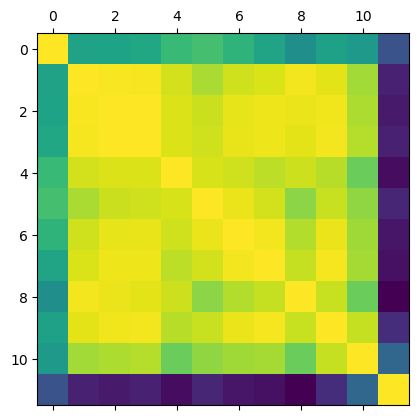

In [132]:
plt.matshow(trans_peo.iloc[:,[x for x in range(3,7)]+[x for x in range(8,16)]].corr())
plt.show()

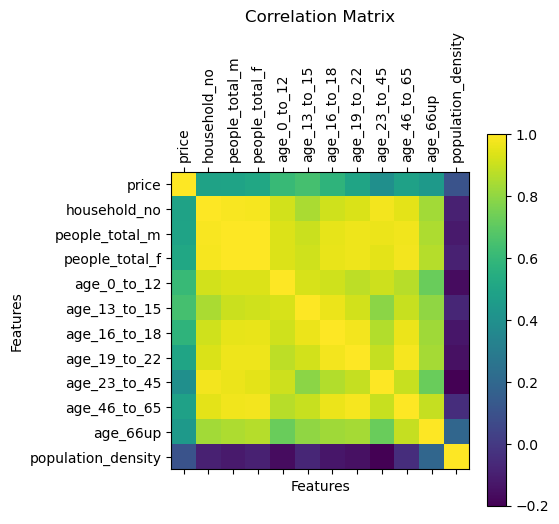

In [133]:
# Assuming trans_peo is your DataFrame
subset = trans_peo.iloc[:, [x for x in range(3, 7)] + [x for x in range(8, 16)]]
corr_matrix = subset.corr()

# Plot the correlation matrix
plt.matshow(corr_matrix, cmap='viridis')

# Add labels and legend
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()

# Add labels for x and y axes
plt.xlabel('Features')
plt.ylabel('Features')

# Add a title
plt.title('Correlation Matrix')

plt.show()

In [134]:
corr_matrix # 應該是正相關的啦～

,price,household_no,people_total_m,people_total_f,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,population_density
price,1.000000,0.488949,0.494136,0.511357,0.609464,0.645810,0.580406,0.498998,0.396324,0.484517,0.446447,0.106244
household_no,0.488949,1.000000,0.987013,0.985701,0.919794,0.848134,0.911890,0.933783,0.977766,0.951614,0.832494,-0.094075
people_total_m,0.494136,0.987013,1.000000,0.996860,0.934905,0.902391,0.955434,0.969064,0.964065,0.975446,0.851666,-0.116399
people_total_f,0.511357,0.985701,0.996860,1.000000,0.937162,0.911970,0.959386,0.969235,0.952646,0.980569,0.867382,-0.092311
age_0_to_12,0.609464,0.919794,0.934905,0.937162,1.000000,0.927773,0.914105,0.879433,0.907006,0.868635,0.726160,-0.162597
age_13_to_15,0.645810,0.848134,0.902391,0.911970,0.927773,1.000000,0.966551,0.915946,0.789269,0.901183,0.801546,-0.071760
age_16_to_18,0.580406,0.911890,0.955434,0.959386,0.914105,0.966551,1.000000,0.979779,0.863143,0.964746,0.830583,-0.128334
age_19_to_22,0.498998,0.933783,0.969064,0.969235,0.879433,0.915946,0.979779,1.000000,0.895058,0.985191,0.837832,-0.148302
age_23_to_45,0.396324,0.977766,0.964065,0.952646,0.907006,0.789269,0.863143,0.895058,1.000000,0.898151,0.727239,-0.203148
age_46_to_65,0.484517,0.951614,0.975446,0.980569,0.868635,0.901183,0.964746,0.985191,0.898151,1.000000,0.895556,-0.047385


In [136]:
subset = trans_peo[trans_peo['site_id']=='新北市板橋區'].iloc[:, [x for x in range(3, 7)] + [x for x in range(8, 16)]]
subset.corr()

,price,household_no,people_total_m,people_total_f,age_0_to_12,age_13_to_15,age_16_to_18,age_19_to_22,age_23_to_45,age_46_to_65,age_66up,population_density
price,1.000000,0.501767,0.377754,0.477450,0.363569,0.478025,-0.168856,-0.012484,0.452679,0.328777,0.574972,NaN
household_no,0.501767,1.000000,0.989748,0.987062,0.919515,0.910023,0.707653,0.718114,0.996639,0.922326,0.934096,NaN
people_total_m,0.377754,0.989748,1.000000,0.984357,0.936534,0.913397,0.772296,0.749325,0.996290,0.920559,0.920466,NaN
people_total_f,0.477450,0.987062,0.984357,1.000000,0.969805,0.947520,0.653389,0.641277,0.990880,0.866367,0.964828,NaN
age_0_to_12,0.363569,0.919515,0.936534,0.969805,1.000000,0.952418,0.582778,0.527558,0.936944,0.753412,0.952764,NaN
age_13_to_15,0.478025,0.910023,0.913397,0.947520,0.952418,1.000000,0.506316,0.422032,0.930360,0.690391,0.990047,NaN
age_16_to_18,-0.168856,0.707653,0.772296,0.653389,0.582778,0.506316,1.000000,0.952230,0.723146,0.860693,0.477259,NaN
age_19_to_22,-0.012484,0.718114,0.749325,0.641277,0.527558,0.422032,0.952230,1.000000,0.708749,0.921915,0.434976,NaN
age_23_to_45,0.452679,0.996639,0.996290,0.990880,0.936944,0.930360,0.723146,0.708749,1.000000,0.907295,0.943411,NaN
age_46_to_65,0.328777,0.922326,0.920559,0.866367,0.753412,0.690391,0.860693,0.921915,0.907295,1.000000,0.723871,NaN


# 市區公車站牌資料

https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Taipei

NantouCounty 可替換城市列表：
https://tdx.transportdata.tw/api/basic/v2/Basic/County / 
https://tdx.transportdata.tw/api/basic/v2/Basic/City

In [70]:
county = pd.read_xml('County.xml')
county.head()

,CityID,County,CountyCode,CountyID,CountyName,Version
0,A,Taipei,63000,A,臺北市,23.09.1
1,B,Taichung,66000,B,臺中市,23.09.1
2,C,Keelung,10017,C,基隆市,23.09.1
3,D,Tainan,67000,D,臺南市,23.09.1
4,E,Kaohsiung,64000,E,高雄市,23.09.1


In [74]:
county_list = county['County'].tolist()
county_list[:3]

['Taipei', 'Taichung', 'Keelung']

In [75]:
['https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/'+x for x in county_list]

['https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Taipei',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Taichung',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Keelung',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Tainan',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Kaohsiung',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/NewTaipei',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/YilanCounty',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Taoyuan',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Chiayi',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/HsinchuCounty',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/MiaoliCounty',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/NantouCounty',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/ChanghuaCounty',
 'https://tdx.transportdata.tw/api/basic/v2/Bus/Stop/City/Hsinchu',
 'https://tdx.trans

In [67]:
# 測試一個
# Specify the file path
xml_file_path = 'NantouCounty.xml'

# Read the content of the XML file
with open(xml_file_path, 'r', encoding='utf-8') as file:
    xml_data = file.read()

# Parse the XML data
root = ET.fromstring(xml_data)

# Define a list to store the parsed data
bus_stop_data = []

# Iterate over each BusStop element
for bus_stop in root.findall('.//{https://ptx.transportdata.tw/standard/schema/}BusStop'):
    stop_uid = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopUID').text
    stop_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopID').text
    authority_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}AuthorityID').text
    stop_name_tw = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopName/{https://ptx.transportdata.tw/standard/schema/}Zh_tw').text
    position_lon = float(bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}PositionLon').text)
    position_lat = float(bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}PositionLat').text)
    geo_hash = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}GeoHash').text
    station_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StationID').text
    station_group_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StationGroupID').text
    city = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}City').text
    city_code = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}CityCode').text
    location_city_code = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}LocationCityCode').text

    # Append data to the list
    bus_stop_data.append([stop_uid, stop_id, authority_id, stop_name_tw, position_lon, position_lat,
                          geo_hash, station_id, station_group_id, city, city_code,
                          location_city_code])

# Create a DataFrame from the list
columns = ['StopUID', 'StopID', 'AuthorityID', 'StopName_TW', 'PositionLon', 'PositionLat',
           'GeoHash', 'StationID', 'StationGroupID', 'City', 'CityCode',
           'LocationCityCode']

bus = pd.DataFrame(bus_stop_data, columns=columns)
bus.head()

,StopUID,StopID,AuthorityID,StopName_TW,PositionLon,PositionLat,GeoHash,StationID,StationGroupID,City,CityCode,LocationCityCode
0,NAN250365,250365,016,坪頂國小,120.739453,23.966765,wsmb77pb9,125050,542－068,NantouCounty,NAN,NAN
1,NAN251292,251292,016,頂城,120.745920,23.968480,wsmb7ek6x,125051,542－069,NantouCounty,NAN,NAN
2,NAN255343,255343,016,道房,120.833586,23.826111,wsjzt9km4,117030,553－022,NantouCounty,NAN,NAN
3,NAN259631,259631,016,中集公司,120.718079,23.833201,wsjze48nr,124579,551－045,NantouCounty,NAN,NAN
4,NAN259685,259685,016,八張,120.795203,23.828042,wsjzscb2k,117023,552－020,NantouCounty,NAN,NAN


In [79]:
# 跑完全部
bus = pd.DataFrame()

# Specify the file path
files = ['bus/'+x+'.xml' for x in ['Taipei', 'NewTaipei', 'Taoyuan', 'Taichung', 'Tainan', 'Kaohsiung']]

for xml_file_path in files:

    # Read the content of the XML file
    with open(xml_file_path, 'r', encoding='utf-8') as file:
        xml_data = file.read()

    # Parse the XML data
    root = ET.fromstring(xml_data)

    # Define a list to store the parsed data
    bus_stop_data = []

    # Iterate over each BusStop element
    for bus_stop in root.findall('.//{https://ptx.transportdata.tw/standard/schema/}BusStop'):
        stop_uid = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopUID').text
        stop_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopID').text
        authority_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}AuthorityID').text
        stop_name_tw = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopName/{https://ptx.transportdata.tw/standard/schema/}Zh_tw').text
        position_lon = float(bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}PositionLon').text)
        position_lat = float(bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}PositionLat').text)
        geo_hash = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StopPosition/{https://ptx.transportdata.tw/standard/schema/}GeoHash').text
        station_id = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}StationID').text
        city = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}City').text
        city_code = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}CityCode').text
        location_city_code = bus_stop.find('{https://ptx.transportdata.tw/standard/schema/}LocationCityCode').text

        # Append data to the list
        bus_stop_data.append([stop_uid, stop_id, authority_id, stop_name_tw, position_lon, position_lat,
                            geo_hash, station_id, city, city_code,
                            location_city_code])

    # Create a DataFrame from the list
    columns = ['StopUID', 'StopID', 'AuthorityID', 'StopName_TW', 'PositionLon', 'PositionLat',
            'GeoHash', 'StationID', 'City', 'CityCode',
            'LocationCityCode']

    bus = pd.concat([bus, pd.DataFrame(bus_stop_data, columns=columns)], axis=0)
print(bus.shape)
bus.head()

(110607, 11)


,StopUID,StopID,AuthorityID,StopName_TW,PositionLon,PositionLat,GeoHash,StationID,City,CityCode,LocationCityCode
0,TPE10000,10000,004,蘆洲總站,121.465804,25.089056,wsqqsp2dq,3698,Taipei,TPE,NWT
1,TPE10001,10001,004,南港分局(重陽),121.596717,25.055561,wsqqx10p0,8627,Taipei,TPE,TPE
2,TPE10002,10002,004,王爺廟口,121.466640,25.088140,wsqqsp1m1,3655,Taipei,TPE,NWT
3,TPE10003,10003,004,中國電視公司,121.599180,25.056460,wsqqx13u6,1612,Taipei,TPE,TPE
4,TPE10004,10004,004,空中大學,121.467798,25.086711,wsqqsnfhs,3670,Taipei,TPE,NWT


In [80]:
bus.to_csv('bus_stop.csv', index=False)

# 鄉鎮市區經緯度

村里界圖(TWD97經緯度)：

https://data.gov.tw/dataset/7438

In [100]:
xml_file_path = 'TW-07-301000100G-613995.xml'

# Read the content of the XML file
with open(xml_file_path, 'r', encoding='utf-8') as file:
    xml_data = file.read()

# Parse the XML data
root = ET.fromstring(xml_data)

root

<Element '{https://www.isotc211.org/2005/gmd}MD_Metadata' at 0x804733f60>

In [102]:
xml_data

'\ufeff<?xml version="1.0" encoding="utf-8"?>\n<gmd:MD_Metadata xmlns:gmd="https://www.isotc211.org/2005/gmd" xmlns:gco="https://www.isotc211.org/2005/gco" xmlns:gml="http://www.opengis.net/gml" xmlns:xlink="https://www.w3.org/1999/xlink" xmlns:xsi="https://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="https://www.isotc211.org/2005/gmd https://www.isotc211.org/2005/gmd/metadataEntity.xsd">\n  <gmd:fileIdentifier>\n    <gco:CharacterString>TW-07-301000100G-613995</gco:CharacterString>\n  </gmd:fileIdentifier>\n  <gmd:language>\n    <gco:CharacterString>chi</gco:CharacterString>\n  </gmd:language>\n  <gmd:characterSet>\n    <gmd:MD_CharacterSetCode codeList="https://www.isotc211.org/2005/resources/codeList.xml#MD_CharacterSetCode" codeListValue="big5" codeSpace="ISOTC211/19115">big5</gmd:MD_CharacterSetCode>\n  </gmd:characterSet>\n  <gmd:parentIdentifier>\n    <gco:CharacterString />\n  </gmd:parentIdentifier>\n  <gmd:contact xlink:type="simple">\n    <gmd:CI_ResponsibleParty>

# 新北市餐飲業者

https://data.ntpc.gov.tw/datasets/8e64b205-a100-4a9a-bd76-8e362761fd61

In [22]:
res = pd.read_csv('新北市餐飲業者.csv')
print(res.shape)
res.head(3)

(800, 14)


,Id,Name,Description,Tel,Add,Zipcode,Opentime,Map,Px,Py,Class,Website,Parkinginfo,Changetime
0,C3_382000000A_211400,渼潞工作坊,沈美露老師說：我的工作坊原本要使用我父親的名字「巴桑」來命名，一方面因為父親很早就過世了，另...,886-2-26616626,新北市233烏來區烏來街12號,233,來電詢問,NaN,121.55151,24.86410,9,NaN,NaN,2021/10/20 16:25:18
1,C3_382000000A_403205,喬麥屋企業有限公司,由初代創辦人開創至今的第三代接班人，喬麥屋製麵已有近百年歷史。喬麥屋不單是台灣第一家提倡小包...,886-2-86853699,新北市238樹林區東順街80-2號,238,週一至週五 8:00-18:00公休日：週六、週日、國定假日,NaN,121.40897,24.97698,9,NaN,NaN,2021/10/03 10:31:06
2,C3_382000000A_208066,我家廚房-美麗新店-紅麴豆乳(2012年特色伴手禮),"我家「紅麴豆乳」以天然養生的""紅麴、糙米""為主要原料，源自福建來台的祖母手藝百分百傳承，風味...",886-2-22156700,新北市231新店區僑信路55號,231,11:30 - 14:00、17:30 - 20:00 / 週一公休、遇國定假日順延一天、每...,NaN,121.49940,24.94947,9,NaN,NaN,2020/07/28 14:07:56


In [146]:
res.columns

Index(['Id', 'Name', 'Description', 'Tel', 'Add', 'Zipcode', 'Opentime', 'Map',
       'Px', 'Py', 'Class', 'Website', 'Parkinginfo', 'Changetime'],
      dtype='object')

In [23]:
keywords = ['早餐', '早午餐', '輕食']
res_bf = res[(res['Name'].str.contains('|'.join(keywords), na=False) | res['Description'].str.contains('|'.join(keywords), na=False))]
# res_bf = res[(res['Name'].str.contains('|'.join(keywords), na=False) | res['Description'].str.contains('|'.join(keywords), na=False)) & res['Add'].str.contains('板橋', na=False)]
res_bf.rename(columns={'Px':'lon', 'Py':'lat'}, inplace=True)
res_bf.reset_index(drop=True, inplace=True)
print(res_bf.shape)
res_bf.head(3)

(25, 14)


/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_26783/1923323237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_bf.rename(columns={'Px':'lon', 'Py':'lat'}, inplace=True)


,Id,Name,Description,Tel,Add,Zipcode,Opentime,Map,lon,lat,Class,Website,Parkinginfo,Changetime
0,C3_382000000A_207262,三隻小豬早餐,軟嫩的蛋捲搭配火腿與起司，加上美味的義式烤三明治與美式培根牛肉堡，輕鬆悠閒的用餐環境讓人想一...,886-2-29530917,新北市220板橋區後埔街54號,220,07:00~15:00（供餐到14:30) 星期一休,NaN,121.46054,25.00576,9,NaN,NaN,2018/12/26 17:59:38
1,C3_382000000A_206322,亞米ya複合式餐飲,亞米ya源自於好吃的意思，早餐店位於社區內，店內窗明几淨，進去用餐讓人有舒服的感覺。座位寬敞...,886-2-29751699,新北市241三重區成功路50巷27號,241,週一至週日06:00 ~ 12:00,NaN,121.48847,25.05000,9,NaN,NaN,2018/12/28 11:00:06
2,C3_382000000A_206422,三芝小豬烘焙屋,這是一家擁有粉紅色外觀，溫馨的小店，店名取得相當逗趣，走進店裡也都充滿了可愛小豬的擺設，彷彿...,886-2-86353045,新北市252三芝區埔尾27號,252,夏季(4月~9月)平日11:00~19:00； 冬季(1月~3月)平日11:00~18:00...,NaN,121.50258,25.24023,9,NaN,NaN,2021/10/20 12:00:00


# 110新北市衛生優良餐飲業者名單

https://www.fda.gov.tw/tc/siteContent.aspx?sid=12008

In [24]:
good_res = pd.read_csv('110新北市衛生優良餐飲業者名單.csv')
print(good_res.shape)
good_res.head(3)

(244, 8)


,編號,食品業者登錄字號,店名,總部評核,電話,地址,餐飲業別,評核等級
0,1,F-112411160-00838-8,麥當勞(永和),是,02-29290101,新北市永和區永和路2段170號,速食業,優
1,2,F-112411160-00842-3,麥當勞(新店北新),是,02-29170186,新北市新店區北新路2段102號,速食業,優
2,3,F-112411160-00859-1,麥當勞(新莊中正),是,02-22768295,新北市新莊區中正路232號,速食業,優


In [25]:
good_res = pd.read_csv('110新北市衛生優良餐飲業者名單_經緯度.csv')
good_res.rename(columns={'longitude':'lon', 'latitude':'lat'}, inplace=True)
print(good_res.shape)
good_res.head(3)

(244, 10)


,編號,食品業者登錄字號,店名,總部評核,電話,地址,餐飲業別,評核等級,lon,lat
0,1,F-112411160-00838-8,麥當勞(永和),是,02-29290101,新北市永和區永和路2段170號,速食業,優,121.512927,25.013181
1,2,F-112411160-00842-3,麥當勞(新店北新),是,02-29170186,新北市新店區北新路2段102號,速食業,優,121.540625,24.973864
2,3,F-112411160-00859-1,麥當勞(新莊中正),是,02-22768295,新北市新莊區中正路232號,速食業,優,121.445786,25.035369


# 地理位置資料

重要地標資訊與競爭者

In [99]:
def twd97_to_lonlat(x=174458.0,y=2525824.0):
    # https://tylerastro.medium.com/twd97-to-longitude-latitude-dde820d83405
    
    """
    Parameters
    ----------
    x : float
        TWD97 coord system. The default is 174458.0.
    y : float
        TWD97 coord system. The default is 2525824.0.
    Returns
    -------
    list
        [longitude, latitude]
    """
    
    a = 6378137
    b = 6356752.314245
    long_0 = 121 * math.pi / 180.0
    k0 = 0.9999
    dx = 250000
    dy = 0
    
    e = math.pow((1-math.pow(b, 2)/math.pow(a,2)), 0.5)
    
    x -= dx
    y -= dy
    
    M = y / k0
    
    mu = M / ( a*(1-math.pow(e, 2)/4 - 3*math.pow(e,4)/64 - 5 * math.pow(e, 6)/256))
    e1 = (1.0 - pow((1   - pow(e, 2)), 0.5)) / (1.0 +math.pow((1.0 -math.pow(e,2)), 0.5))
    
    j1 = 3*e1/2-27*math.pow(e1,3)/32
    j2 = 21 * math.pow(e1,2)/16 - 55 * math.pow(e1, 4)/32
    j3 = 151 * math.pow(e1, 3)/96
    j4 = 1097 * math.pow(e1, 4)/512
    
    fp = mu + j1 * math.sin(2*mu) + j2 * math.sin(4* mu) + j3 * math.sin(6*mu) + j4 * math.sin(8* mu)
    
    e2 = math.pow((e*a/b),2)
    c1 = math.pow(e2*math.cos(fp),2)
    t1 = math.pow(math.tan(fp),2)
    r1 = a * (1-math.pow(e,2)) / math.pow( (1-math.pow(e,2)* math.pow(math.sin(fp),2)), (3/2))
    n1 = a / math.pow((1-math.pow(e,2)*math.pow(math.sin(fp),2)),0.5)
    d = x / (n1*k0)
    
    q1 = n1* math.tan(fp) / r1
    q2 = math.pow(d,2)/2
    q3 = ( 5 + 3 * t1 + 10 * c1 - 4 * math.pow(c1,2) - 9 * e2 ) * math.pow(d,4)/24
    q4 = (61 + 90 * t1 + 298 * c1 + 45 * math.pow(t1,2) - 3 * math.pow(c1,2) - 252 * e2) * math.pow(d,6)/720
    lat = fp - q1 * (q2 - q3 + q4)
    
    
    q5 = d
    q6 = (1+2*t1+c1) * math.pow(d,3) / 6
    q7 = (5 - 2 * c1 + 28 * t1 - 3 * math.pow(c1,2) + 8 * e2 + 24 * math.pow(t1,2)) * math.pow(d,5) / 120
    lon = long_0 + (q5 - q6 + q7) / math.cos(fp)
    
    lat = (lat*180) / math.pi
    lon = (lon*180) / math.pi
    return [lon, lat]

## 新北市
https://data.ntpc.gov.tw/datasets/6dcff24a-838c-40fb-a9df-f1160afafe84

In [96]:
mark = pd.read_csv('新北市重要地標資訊.csv')
print(mark.shape)
mark.head(3)

(1937, 9)


,地標類型,地標名稱,地址,電話,網址,TWD97_X,TWD97_Y,更新日期,行政區
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,02-29052000,NaN,293829.74,2769474.64,2023-11-27 17:12:02.65,新莊區
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,02-28102292,NaN,292919.33,2787131.17,2023-11-27 17:12:02.65,淡水區
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,02-22733567,NaN,296082.43,2762923.08,2023-11-27 17:12:02.65,土城區


In [98]:
zip(mark['TWD97_X'],mark['TWD97_Y'])

In [100]:
mark[['lon', 'lat']] = mark.apply(lambda row: pd.Series(twd97_to_lonlat(row['TWD97_X'], row['TWD97_Y'])), axis=1)
mark.head(3)

,地標類型,地標名稱,地址,電話,網址,TWD97_X,TWD97_Y,更新日期,行政區,lon,lat
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,02-29052000,NaN,293829.74,2769474.64,2023-11-27 17:12:02.65,新莊區,121.434328,25.032744
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,02-28102292,NaN,292919.33,2787131.17,2023-11-27 17:12:02.65,淡水區,121.425859,25.192173
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,02-22733567,NaN,296082.43,2762923.08,2023-11-27 17:12:02.65,土城區,121.456432,24.973529


In [151]:
mark['地標類型'].drop_duplicates().tolist()

['大專院校',
 '公所',
 '戶政事務所',
 '火車站',
 '地政事務所',
 '地區醫院',
 '完全中學',
 '災害應變中心',
 '防災公園',
 '其他機關',
 '直升機起降場',
 '核安防護站',
 '核安集結點',
 '消防機關',
 '海嘯避難大樓',
 '海嘯避難高地',
 '高中職',
 '區域醫院',
 '國民小學',
 '國民中學',
 '捷運站',
 '教育研究機構',
 '稅捐機關',
 '監理機關',
 '衛生所',
 '縣市政府',
 '避難收容處所',
 '醫學中心',
 '警察機關']

In [101]:
# 便利性地標
# want_mark = ['大專院校','火車站','地區醫院','完全中學','高中職','區域醫院','國民小學','國民中學','捷運站']
want_mark = ['大專院校','地區醫院','完全中學','高中職','區域醫院','國民小學','國民中學']
want_mark_df = mark[mark['地標類型'].isin(want_mark)]
print(want_mark_df.shape)
want_mark_df.head(3)

(435, 11)


,地標類型,地標名稱,地址,電話,網址,TWD97_X,TWD97_Y,更新日期,行政區,lon,lat
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,02-29052000,NaN,293829.74,2769474.64,2023-11-27 17:12:02.65,新莊區,121.434328,25.032744
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,02-28102292,NaN,292919.33,2787131.17,2023-11-27 17:12:02.65,淡水區,121.425859,25.192173
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,02-22733567,NaN,296082.43,2762923.08,2023-11-27 17:12:02.65,土城區,121.456432,24.973529


In [13]:
want_mark_df[['lon','lat']].describe()

,lon,lat
count,548.000000,548.000000
mean,121.507079,25.041372
std,0.126783,0.082188
min,121.313017,24.777317
25%,121.437185,24.985494
50%,121.469796,25.024095
75%,121.520927,25.079427
max,121.988470,25.291881


In [102]:
want_mark_df[['地標類型','地標名稱','地址','TWD97_X','TWD97_Y','lon','lat']].to_pickle('重要地標/新北市重要地標.pkl')

In [14]:
# 前面的公車拿進來
bus = pd.read_csv('bus_stop.csv')
bus.head(3)

,StopUID,StopID,AuthorityID,StopName_TW,PositionLon,PositionLat,GeoHash,StationID,City,CityCode,LocationCityCode
0,TPE10000,10000,4,蘆洲總站,121.465804,25.089056,wsqqsp2dq,3698,Taipei,TPE,NWT
1,TPE10001,10001,4,南港分局(重陽),121.596717,25.055561,wsqqx10p0,8627,Taipei,TPE,TPE
2,TPE10002,10002,4,王爺廟口,121.466640,25.088140,wsqqsp1m1,3655,Taipei,TPE,NWT


In [15]:
bus_nt = bus[bus['City']=='NewTaipei']
bus_nt.rename(columns={'PositionLon': 'lon', 'PositionLat': 'lat'}, inplace=True)
print(bus_nt.shape)
bus_nt.head(3)

(32557, 11)


/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_26783/1893866435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_nt.rename(columns={'PositionLon': 'lon', 'PositionLat': 'lat'}, inplace=True)


,StopUID,StopID,AuthorityID,StopName_TW,lon,lat,GeoHash,StationID,City,CityCode,LocationCityCode
27955,NWT10353,10353,5,管理中心,121.457635,25.063771,wsqqefdz0,235,NewTaipei,NWT,NWT
27956,NWT10354,10354,5,標準廠房,121.455960,25.064960,wsqqefctb,36007,NewTaipei,NWT,NWT
27957,NWT10355,10355,5,五權三五工路口,121.453673,25.065315,wsqqeepb5,1000841,NewTaipei,NWT,NWT


## 臺中市

重要地標(111年版)

https://opendata.taichung.gov.tw/search/ece54e87-c8a2-471e-816c-6c367ee88d7b

臺中市地形圖地標分類代碼表

https://opendata.taichung.gov.tw/search/ca1cd59d-a3ae-403c-93c6-ac8895cd8bff

In [103]:
def read_shapefile(shp_path):
	"""
	Read a shapefile into a Pandas dataframe with a 'coords' column holding
	the geometry information. This uses the pyshp package
	"""
	# source: https://gist.github.com/aerispaha/f098916ac041c286ae92d037ba5c37ba
	import shapefile

	#read file, parse out the records and shapes
	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records = sf.records()
	shps = [s.points for s in sf.shapes()]

	#write into a dataframe
	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)

	return df

In [104]:
mark = read_shapefile('台中/111_M0001_UTF8_全.shp')
print(mark.shape)
mark.head(3)

(18495, 12)


,ID,M1A,M1B,M1C,M1D,M1E,M1F,M1G,M1H,M1I,M1J,coords
0,1,M0001,202367.502,2681967.387,0301,公共設施,公園,兒三公園,兒三公園,,自強三街與自強三街64巷口,"[[202367.50200000033, 2681967.387]]"
1,2,M0001,202416.319,2681767.867,0301,公共設施,公園,兒二公園,兒二公園,,自強二街與自強二街28巷口,"[[202416.31900000013, 2681767.8670000006]]"
2,3,M0001,201782.072,2683578.854,0301,公共設施,公園,濱海公園,濱海公園,,中一路旁,"[[201782.0724759968, 2683578.853954026]]"


In [17]:
mark['M1E'].value_counts()

M1E
醫療保健      4437
民間單位      3654
公共設施      1552
文教機構      1497
便利商店      1383
宗教機構      1268
政府機關       994
金融機構       808
民代服務處      701
飯店(餐飲)     669
運輸服務       524
百貨公司       440
育樂場所       324
警消單位       211
其他建物        33
Name: count, dtype: int64

In [105]:
# 便利性地標
want_mark = ['醫療保健','文教機構','運輸服務']
want_mark_df = mark[mark['M1E'].isin(want_mark)]
print(want_mark_df.shape)
want_mark_df.head(3)

(6458, 12)


,ID,M1A,M1B,M1C,M1D,M1E,M1F,M1G,M1H,M1I,M1J,coords
738,739,M0001,218708.454,2673494.064,0101,文教機構,托嬰中心,臺中市私立史丹佛托嬰中心,私立史丹佛托嬰中心,,406臺中市北屯區青島路四段219號,"[[218708.45430000033, 2673494.0643000007]]"
739,740,M0001,217793.123,2667672.289,0101,文教機構,托嬰中心,臺中市私立皇家寶貝托嬰中心,私立皇家寶貝托嬰中心,,412臺中市大里區來興街47號,"[[217793.12310000043, 2667672.2887999993]]"
740,741,M0001,211185.284,2675559.445,0101,文教機構,托嬰中心,臺中市私立巨采福科托嬰中心,私立巨采福科托嬰中心,,407臺中市西屯區福科路535巷2號,"[[211185.28440000024, 2675559.4451]]"


In [24]:
want_mark_df['M1F'].value_counts()

M1F
診所        3242
幼兒園        793
健保藥局       791
加油站        305
小學         243
護理機構       229
醫院         175
托嬰中心       135
國中          79
高中          60
古蹟文物        59
自行車道設施      59
圖書館         58
捷運          47
汽車轉運站       47
交流道         41
大專院校        35
火車站         23
文化中心        14
親子館         12
博物館          7
美術館          2
高鐵           1
機場           1
Name: count, dtype: int64

In [106]:
want_mark = ['診所','小學','醫院','國中','高中','大專院校']
want_mark_df = want_mark_df[want_mark_df['M1F'].isin(want_mark)]
print(want_mark_df.shape)
want_mark_df.head(3)

(3834, 12)


,ID,M1A,M1B,M1C,M1D,M1E,M1F,M1G,M1H,M1I,M1J,coords
873,874,M0001,216249.599,2675563.996,0103,文教機構,小學,臺中市北屯區陳平國民小學,陳平國民小學,,406臺中市北屯區陳平路58號,"[[216249.59852910042, 2675563.9963465747]]"
874,875,M0001,216302.590,2670465.597,0103,文教機構,小學,臺中市西區忠信國民小學,忠信國民小學,,403臺中市西區林森路155號,"[[216302.58999999985, 2670465.596999999]]"
875,876,M0001,216355.258,2674038.039,0103,文教機構,小學,臺中市北區立人國民小學,立人國民小學,,404臺中市北區北平路一段60號,"[[216355.25782539972, 2674038.0388301746]]"


In [35]:
want_mark_df['coords'].iloc[0][0][0]

216249.59852910042

In [36]:
want_mark_df['coords'].iloc[0][0][1]

2675563.9963465747

In [107]:
want_mark_df[['lon', 'lat']] = want_mark_df.apply(lambda row: pd.Series(twd97_to_lonlat(row['M1B'], row['M1C'])), axis=1)
want_mark_df.head(3)

,ID,M1A,M1B,M1C,M1D,M1E,M1F,M1G,M1H,M1I,M1J,coords,lon,lat
873,874,M0001,216249.599,2675563.996,0103,文教機構,小學,臺中市北屯區陳平國民小學,陳平國民小學,,406臺中市北屯區陳平路58號,"[[216249.59852910042, 2675563.9963465747]]",120.667798,24.185111
874,875,M0001,216302.590,2670465.597,0103,文教機構,小學,臺中市西區忠信國民小學,忠信國民小學,,403臺中市西區林森路155號,"[[216302.58999999985, 2670465.596999999]]",120.668438,24.139078
875,876,M0001,216355.258,2674038.039,0103,文教機構,小學,臺中市北區立人國民小學,立人國民小學,,404臺中市北區北平路一段60號,"[[216355.25782539972, 2674038.0388301746]]",120.668873,24.171335


In [108]:
want_mark_df.rename(columns={'M1F':'地標類型', 'M1G':'地標名稱', 'M1J':'地址', 'M1B':'TWD97_X', 'M1C':'TWD97_Y'}, inplace=True)
want_mark_df[['地標類型','地標名稱','地址','TWD97_X','TWD97_Y','lon','lat']].to_pickle('重要地標/台中市重要地標.pkl')

## 台北市

https://scidm.nchc.org.tw/zh_TW/dataset/best_wish116506/resource/6534f418-0cdd-4373-82e0-21fef17a8300

https://sheethub.com/nlsc.gov.tw/國土繪製中心_地標資訊_台北

In [109]:
# mark = pd.read_csv('台北市.csv')
mark = pd.read_csv('台北市地標.csv')
print(mark.shape)
mark.head(3)

(7145, 8)


,縣市代號,縣市,大類別,小類別代號,小類別名稱,地標名稱,緯度,經度
0,A,臺北市,交通運輸,13,捷運站,萬隆捷運站-出口1,25.001319,121.538839
1,A,臺北市,交通運輸,13,捷運站,萬隆捷運站-出口3,25.002271,121.539089
2,A,臺北市,交通運輸,15,高鐵站,高鐵臺北站-南一門,25.047042,121.517511


In [129]:
mark['小類別名稱'].value_counts()

小類別名稱
行政機關       1460
停車場地       1391
觀光遊憩設施     1023
國小          528
一般公園        497
服務性設施       392
飯店          345
金融機構        329
捷運站         237
國中          149
醫療保健        134
大學及研究所      129
高中          120
加油站          84
生活百貨量販       78
傳統市場         62
客運站          44
百貨公司         38
主要道路建設       30
娛樂設施         21
幼稚園、托兒所      19
高鐵站          13
火車站           9
專科            6
碼頭            4
航空站           2
里鄰公園          1
Name: count, dtype: int64

In [110]:
# 便利性地標
# want_mark = ['國小','捷運站','國中','醫療保健','大學及研究所','高中','客運站','高鐵站','火車站','專科']
want_mark = ['國小','國中','醫療保健','大學及研究所','高中','客運站','專科']
want_mark_df = mark[mark['小類別名稱'].isin(want_mark)]
print(want_mark_df.shape)
want_mark_df.head(3)

(1110, 8)


,縣市代號,縣市,大類別,小類別代號,小類別名稱,地標名稱,緯度,經度
5,A,臺北市,公共建設,21,國小,市立劍潭國小,25.079543,121.522751
6,A,臺北市,公共建設,21,國小,市立葫蘆國小,25.083388,121.507560
7,A,臺北市,公共建設,21,國小,市立士林國中,25.094350,121.522576


In [111]:
want_mark_df.rename(columns={'小類別名稱':'地標類型', '經度':'lon', '緯度':'lat'}, inplace=True)
want_mark_df[['地標類型','地標名稱','lon','lat']].to_pickle('重要地標/台北市重要地標.pkl')

/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_6495/3955795071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  want_mark_df.rename(columns={'小類別名稱':'地標類型', '經度':'lon', '緯度':'lat'}, inplace=True)


In [ ]:
# want_mark = [8, # 國中小
#              17, # 診所
#              22, # MRT
#              # 30, # movie
#              42, # 醫院
#              # check to 66
#              ]

In [122]:
# mark[mark['mark_ops_id']==66].head(5)

,mslink,mark_num,mark_markid,mark_name,mark_addr,mark_xcoor67,mark_ycoor67,mark_xcoor97,mark_ycoor97,mark_long,mark_lat,markcode,mark_addr_Sourec,mark_ops_id,errInfo
13538,435354,435354,18100100001,"內2,內溝",內溝溪左岸中山高速公路南側堤外便道(吉林汽車旅館旁),311517.858,2773418.065,312348.763,2773214.085,121.618124,25.065853,10508000,NaN,66,NaN
13539,435355,435355,18100100002,"內1,康樂",內溝溪右岸中山高速公路下方,311488.783,2773433.165,312319.688,2773229.185,121.617836,25.065990,10508000,NaN,66,NaN
13540,435356,435356,18100100003,"基16,美堤",大直樂群一路、敬業三路底,305292.814,2774630.251,306123.719,2774426.271,121.556472,25.077041,10508000,NaN,66,NaN
13541,435357,435357,18100100004,"基13,成美",內湖區新明路219巷底,308501.074,2772464.922,309331.979,2772260.942,121.588181,25.057369,10508000,NaN,66,NaN
13542,435358,435358,18100100005,"基12,長壽",內湖區安康路32巷底,309177.818,2772861.326,310008.723,2772657.346,121.594906,25.060921,10508000,NaN,66,NaN


## 合併資料 

In [112]:
citys = ['新北市','台中市','台北市']
mark_all = pd.DataFrame()
for city in citys:
    temp = pd.read_pickle('重要地標/'+city+'重要地標.pkl')
    temp['縣市'] = [city]*len(temp)
    mark_all = pd.concat([mark_all, temp], axis=0)
print(mark_all.shape)
mark_all.head(3)

(5379, 8)


,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市


In [134]:
mark_all.to_pickle('重要地標/北北中重要地標.pkl')

## 車站資料

In [113]:
# Parse the XML file
tree = ET.parse('station/train.xml')
root = tree.getroot()

# Initialize lists to store data
station_uid = []
station_id = []
zh_tw = []
en = []
lon = []
lat = []
address = []
phone = []
station_class = []
url = []
city = []

# Iterate through each 'Station' element in the XML
for station_elem in root.findall('.//Station'):
    # Extract data from each 'Station' element
    # station_uid.append(station_elem.find('StationUID').text)
    # station_id.append(station_elem.find('StationID').text)
    zh_tw.append(station_elem.find('.//Zh_tw').text)
    # en.append(station_elem.find('.//En').text)
    lon.append(float(station_elem.find('.//PositionLon').text))
    lat.append(float(station_elem.find('.//PositionLat').text))
    address.append(station_elem.find('StationAddress').text)
    # phone.append(station_elem.find('StationPhone').text)
    # station_class.append(int(station_elem.find('StationClass').text))
    # url.append(station_elem.find('StationURL').text)
    address_without_digits = re.sub(r'^\d*', '', station_elem.find('StationAddress').text)
    city.append(address_without_digits[:3])

# Create a DataFrame
data = {
    # 'StationUID': station_uid,
    # 'StationID': station_id,
    '地標名稱': zh_tw,
    # 'En': en,
    'lon': lon,
    'lat': lat,
    '地址': address,
    # 'StationPhone': phone,
    # 'StationClass': station_class,
    # 'StationURL': url
    '地標類型': ['火車']*len(zh_tw),
    '縣市': city
}

train_df = pd.DataFrame(data)

print(train_df.shape)
train_df.head(3)

(243, 6)


,地標名稱,lon,lat,地址,地標類型,縣市
0,基隆,121.73997,25.13411,1041基隆市中山區民治里1鄰中山一路16之 1號,火車,基隆市
1,三坑,121.74202,25.12305,20045基隆市仁愛區德厚里龍安街 206 號,火車,基隆市
2,八堵,121.72898,25.10843,20541基隆市暖暖區八南里八堵路 142 號,火車,基隆市


In [114]:
# Parse the XML file
tree = ET.parse('station/high_speed.xml')
root = tree.getroot()

# Create empty lists to store data
station_data = []

# Iterate through RailStation elements
for rail_station in root.findall('RailStation'):
    station_info = {}
    position = rail_station.find('StationPosition')
    station_info['lon'] = float(position.find('PositionLon').text)
    station_info['lat'] = float(position.find('PositionLat').text)
    # station_info['GeoHash'] = position.find('GeoHash').text
    station_info['縣市'] = rail_station.find('LocationCity').text
    # station_info['LocationCityCode'] = rail_station.find('LocationCityCode').text
    # station_info['LocationTown'] = rail_station.find('LocationTown').text
    # station_info['LocationTownCode'] = rail_station.find('LocationTownCode').text
    # station_info['StationUID'] = rail_station.find('StationUID').text
    # station_info['StationID'] = rail_station.find('StationID').text
    # station_info['StationCode'] = rail_station.find('StationCode').text
    station_name = rail_station.find('StationName')
    station_info['地標名稱'] = station_name.find('Zh_tw').text
    # station_info['En'] = station_name.find('En').text
    # station_info['StationAddress'] = rail_station.find('StationAddress').text
    # station_info['OperatorID'] = rail_station.find('OperatorID').text
    # station_info['UpdateTime'] = rail_station.find('UpdateTime').text
    # station_info['VersionID'] = rail_station.find('VersionID').text

    # Append station information to the list
    station_data.append(station_info)

# Create a DataFrame from the list of station data
high_df = pd.DataFrame(station_data)
high_df['地標類型'] = ['高鐵']*len(high_df)

print(high_df.shape)
high_df.head(3)

(12, 5)


,lon,lat,縣市,地標名稱,地標類型
0,121.606782,25.053241,臺北市,南港,高鐵
1,121.516983,25.047670,臺北市,台北,高鐵
2,121.464286,25.013690,新北市,板橋,高鐵


In [115]:
# Parse the XML file
MRT_df = pd.DataFrame()
MRT_list = ['安坑輕軌', '新北捷運', '桃園捷運', '淡海輕軌', '台中捷運', '台北捷運', '高雄捷運', '高雄輕軌']
for MRT in MRT_list:
    tree = ET.parse('station/'+MRT+'.xml')
    root = tree.getroot()

    # Create empty lists to store data
    station_data = []

    # Iterate through Station elements
    for station in root.findall('Station'):
        station_info = {}
        position = station.find('StationPosition')
        station_info['lon'] = float(position.find('PositionLon').text)
        station_info['lat'] = float(position.find('PositionLat').text)
        # station_info['GeoHash'] = position.find('GeoHash').text
        station_info['縣市'] = station.find('LocationCity').text
        # station_info['LocationCityCode'] = station.find('LocationCityCode').text
        # station_info['LocationTown'] = station.find('LocationTown').text
        # station_info['LocationTownCode'] = station.find('LocationTownCode').text
        # station_info['StationUID'] = station.find('StationUID').text
        # station_info['StationID'] = station.find('StationID').text
        station_name = station.find('StationName')
        station_info['地標名稱'] = MRT+'_'+station_name.find('Zh_tw').text
        # station_info['En'] = station_name.find('En').text
        # station_info['BikeAllowOnHoliday'] = station.find('BikeAllowOnHoliday').text
        # station_info['SrcUpdateTime'] = station.find('SrcUpdateTime').text
        # station_info['UpdateTime'] = station.find('UpdateTime').text
        # station_info['VersionID'] = station.find('VersionID').text
        station_info['地標類型'] = '捷運'

        # Append station information to the list
        station_data.append(station_info)

    # Create a DataFrame from the list of station data
    MRT_df = pd.concat([MRT_df, pd.DataFrame(station_data)], axis=0)

print(MRT_df.shape)
MRT_df.head(3)

(267, 5)


,lon,lat,縣市,地標名稱,地標類型
0,121.489645,24.946321,新北市,安坑輕軌_雙城,捷運
1,121.493861,24.950760,新北市,安坑輕軌_玫瑰中國城,捷運
2,121.499389,24.953685,新北市,安坑輕軌_台北小城,捷運


## 手動抓取

https://maps.nlsc.gov.tw/T09/mobilemap.action

In [116]:
school_med = pd.read_csv('重要地標/台南、高雄、桃園醫院學校.csv')
print(school_med.shape)
school_med.head(3)

(22, 4)


,縣市,lon,lat,地標類型
0,台南市,120.179246,23.007327,學校
1,高雄市,120.314860,22.663318,學校
2,高雄市,120.340441,22.643612,學校


## 合併資料

In [69]:
mark_all = pd.read_pickle('重要地標/北北中重要地標.pkl')
mark_all.head(3)

,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市


In [117]:
mark_all = pd.concat([mark_all, train_df, high_df, MRT_df, school_med], axis=0)
print(mark_all.shape)
mark_all

(5923, 8)


,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市
3,大專院校,私立亞東科技大學,新北市板橋區華東里18鄰四川路二段58號,295738.24,2765319.13,121.453102,24.995171,新北市
4,大專院校,私立明志科技大學,新北市泰山區貴子里9鄰工專路84號,292609.02,2770340.67,121.422259,25.040597,新北市
...,...,...,...,...,...,...,...,...
17,學校,NaN,NaN,NaN,NaN,121.217210,24.856272,桃園市
18,學校,NaN,NaN,NaN,NaN,121.214993,24.856853,桃園市
19,學校,NaN,NaN,NaN,NaN,121.216592,24.858781,桃園市
20,學校,NaN,NaN,NaN,NaN,121.214579,24.853706,桃園市


In [118]:
# 篩選六都
six_city = ['新北市','台北市','桃園市','台中市','台南市','高雄市','臺北市','臺中市','臺南市']

mark_all_filter = mark_all[mark_all['縣市'].isin(six_city)]
print(mark_all_filter.shape)
mark_all_filter.head(3)

(5769, 8)


,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市


In [119]:
mark_all_filter.to_pickle('六都重要地標.pkl')

In [120]:
mark_all_filter['縣市'] = mark_all_filter['縣市'].apply(lambda x: re.sub('台','臺',x))
mark_all_filter['縣市'].value_counts()

/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_6495/4018825011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mark_all_filter['縣市'] = mark_all_filter['縣市'].apply(lambda x: re.sub('台','臺',x))


縣市
臺中市    3876
臺北市    1204
新北市     538
高雄市      96
桃園市      36
臺南市      19
Name: count, dtype: int64

In [153]:
mark_all_filter.to_pickle('六都重要地標.pkl')
mark_all_filter.head(3)

,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市


# 方圓計算

In [7]:
info.head(3)

,blur_restaurant_uuid,addr_city,addr_district,addr_village,2023-10-07,2023-10-08,2023-10-09,2023-10-10,2023-10-11,2023-10-12,2023-10-13
0,r71ee64,臺中市,北區,賴旺里,06:30-15:00,06:30-15:00,07:30-14:30,NaN,06:00-14:00,06:00-14:00,06:00-14:30
1,rec62b3,臺中市,北區,五常里,05:30-13:30,05:30-13:00,05:30-13:30,05:30-13:30,05:30-13:00,07:00-13:30,06:00-13:30
2,rfa1ab3,臺中市,北屯區,北京里,08:00-15:00,07:30-16:00,08:00-16:00,08:00-15:30,NaN,08:30-15:00,08:00-13:30


In [5]:
bq_res = pd.read_csv('板橋區座標.csv')
print(bq_res.shape)
bq_res

(5, 3)


,Unnamed: 0,x,y
0,華貴里,25.002371,121.456088
1,新民里,25.015107,121.463354
2,光復里,25.019262,121.482970
3,文化里,25.027775,121.467554
4,漢生里,25.015277,121.459971


In [6]:
bq_res.rename(columns={'Unnamed: 0': 'addr_village', 'x': 'lat', 'y': 'lon'}, inplace=True)
bq_res = bq_res.merge(info, how='left', on=['addr_village'])
bq_res

,addr_village,lat,lon,blur_restaurant_uuid,addr_city,addr_district,2023-10-07,2023-10-08,2023-10-09,2023-10-10,2023-10-11,2023-10-12,2023-10-13
0,華貴里,25.002371,121.456088,rcf444b,新北市,板橋區,07:00-14:30,06:30-15:00,07:30-14:00,07:00-15:00,NaN,07:00-14:30,06:30-15:00
1,新民里,25.015107,121.463354,rde2f7e,新北市,板橋區,05:30-19:00,05:00-13:30,05:30-19:30,05:00-15:30,04:30-13:30,04:30-13:00,04:30-13:30
2,光復里,25.019262,121.482970,r4c8016,新北市,板橋區,05:30-14:30,05:00-14:30,06:00-15:00,05:30-14:30,NaN,06:00-14:00,05:30-14:00
3,文化里,25.027775,121.467554,r9ae7da,新北市,板橋區,08:00-15:30,08:00-15:30,08:00-15:00,08:00-15:30,07:30-15:00,07:30-15:00,07:30-15:00
4,漢生里,25.015277,121.459971,rf767b1,新北市,板橋區,08:00-16:00,08:00-15:30,08:00-15:30,08:00-15:30,07:30-15:30,07:30-15:00,07:30-15:00


In [16]:
# 重要地標
want_mark_df.head(3)

,地標類型,地標名稱,地址,電話,網址,TWD97_X,TWD97_Y,更新日期,行政區,lon,lat
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,02-29052000,NaN,293829.74,2769474.64,2023-11-27 17:12:02.65,新莊區,121.434328,25.032744
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,02-28102292,NaN,292919.33,2787131.17,2023-11-27 17:12:02.65,淡水區,121.425859,25.192173
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,02-22733567,NaN,296082.43,2762923.08,2023-11-27 17:12:02.65,土城區,121.456432,24.973529


In [17]:
# 公車站牌
bus_nt.head(3)

,StopUID,StopID,AuthorityID,StopName_TW,lon,lat,GeoHash,StationID,City,CityCode,LocationCityCode
27955,NWT10353,10353,5,管理中心,121.457635,25.063771,wsqqefdz0,235,NewTaipei,NWT,NWT
27956,NWT10354,10354,5,標準廠房,121.455960,25.064960,wsqqefctb,36007,NewTaipei,NWT,NWT
27957,NWT10355,10355,5,五權三五工路口,121.453673,25.065315,wsqqeepb5,1000841,NewTaipei,NWT,NWT


In [121]:
print(mark_all_filter.shape)
mark_all_filter.head(3)

(5769, 8)


,地標類型,地標名稱,地址,TWD97_X,TWD97_Y,lon,lat,縣市
0,大專院校,私立天主教輔仁大學,新北市新莊區營盤里19鄰中正路510號,293829.74,2769474.64,121.434328,25.032744,新北市
1,大專院校,私立台北海洋科技大學淡水校區,新北市淡水區沙崙里8鄰濱海路三段150號,292919.33,2787131.17,121.425859,25.192173,新北市
2,大專院校,私立宏國德霖科技大學,新北市土城區清化里1鄰青雲路380巷1號,296082.43,2762923.08,121.456432,24.973529,新北市


In [122]:
# 計算重要地標數量
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).meters # taking pair of (lat, lon) tuples

info_coord['num_want_mark'] = 0  # 初始化 num_want_mark 列

for index, restaurant in info_coord.iterrows():
    restaurant_coordinates = (restaurant['lat'], restaurant['lon'])
    distances = [calculate_distance(restaurant_coordinates, (marks['lat'], marks['lon'])) for _, marks in mark_all_filter.iterrows()]
    marks_within_m = sum(distance <= 500 for distance in distances)
    info_coord.at[index, 'num_want_mark'] = marks_within_m

info_coord
# 16.8s

,縣市,addr_district,addr_village,lat,lon,num_want_mark
0,臺中市,北區,賴旺里,24.172038,120.673495,47
1,臺中市,北區,五常里,24.154454,120.681675,35
2,臺中市,北屯區,北京里,24.162347,120.692539,50
3,臺中市,南區,福平里,24.127956,120.663696,21
4,臺中市,南屯區,大業里,24.152642,120.651376,84
5,臺中市,大甲區,文武里,24.352075,120.622707,16
6,臺中市,大里區,新里里,24.101547,120.675389,12
7,臺中市,大雅區,大楓里,24.228441,120.667409,0
8,臺中市,烏日區,榮泉里,24.113192,120.592617,2
9,臺中市,西屯區,西平里,24.182988,120.646553,6


In [133]:
# +bus data
info_coord['縣市'] = info_coord['縣市'].apply(lambda x: re.sub('臺','台',x))
info_coord.rename(columns={'縣市':'addr_city'}, inplace=True)

bus_count = pd.read_pickle('bus_stop.pkl')
bus_count.drop(columns=['經度','緯度'], inplace=True)
bus_count.head(3)

,addr_city,addr_district,addr_village,bus_stop
0,台中市,北區,賴旺里,0
1,台中市,北區,五常里,0
2,台中市,北屯區,北京里,0


In [135]:
info_coord = info_coord.merge(bus_count, how='left')
print(info_coord.shape)
info_coord.head(3)

(40, 7)


,addr_city,addr_district,addr_village,lat,lon,num_want_mark,bus_stop
0,台中市,北區,賴旺里,24.172038,120.673495,47,0
1,台中市,北區,五常里,24.154454,120.681675,35,0
2,台中市,北屯區,北京里,24.162347,120.692539,50,0


In [136]:
info_coord['num_mark'] = info_coord['num_want_mark']+info_coord['bus_stop']
print(info_coord.shape)
info_coord.head(3)

(40, 8)


,addr_city,addr_district,addr_village,lat,lon,num_want_mark,bus_stop,num_mark
0,台中市,北區,賴旺里,24.172038,120.673495,47,0,47
1,台中市,北區,五常里,24.154454,120.681675,35,0,35
2,台中市,北屯區,北京里,24.162347,120.692539,50,0,50


In [137]:
info_coord.to_pickle('各里重要地標數量.pkl')

In [141]:
# 競爭者計算
comp = pd.read_pickle('111各縣市優良餐飲業.pkl')
comp.rename(columns={'longitude':'lon', 'latitude':'lat'}, inplace=True)
print(comp.shape)
comp.head(3)

(1131, 6)


,縣市,店名,地址,餐飲業別,lon,lat
0,桃園市,Q Burger-八德忠勇店,桃園市八德區忠勇街297號,早餐業,121.301364,24.964498
1,桃園市,Q Burger-中壢中北店,桃園市中壢區中北路22號1樓,早餐業,121.233623,24.955712
2,桃園市,Q Burger-中壢榮安店,桃園市中壢區榮安十三街230號,早餐業,121.257101,24.962157


In [140]:
comp['餐飲業別'].drop_duplicates().tolist()

['早餐業', '速食店', '速食業', '連鎖餐飲業總部', '早餐店']

In [142]:
# 計算競爭者影響
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).meters # taking pair of (lat, lon) tuples

info_coord['num_competitor'] = 0  # 初始化
info_coord['mean_competitor_distance'] = 0

for index, restaurant in info_coord.iterrows():
    restaurant_coordinates = (restaurant['lat'], restaurant['lon'])
    distances = [calculate_distance(restaurant_coordinates, (marks['lat'], marks['lon'])) for _, marks in comp.iterrows()]
    distances_500 = [distance for distance in distances if distance <= 500]
    marks_within_m = len(distances_500)
    sum_distances = sum(distances_500)
    info_coord.at[index, 'num_competitor'] = marks_within_m
    info_coord.at[index, 'mean_competitor_distance'] = sum_distances/marks_within_m if marks_within_m != 0 else 0

info_coord
# 11.1s

,addr_city,addr_district,addr_village,lat,lon,num_want_mark,bus_stop,num_mark,num_competitor,mean_competitor_distance
0,台中市,北區,賴旺里,24.172038,120.673495,47,0,47,2,296.223296
1,台中市,北區,五常里,24.154454,120.681675,35,0,35,2,264.608801
2,台中市,北屯區,北京里,24.162347,120.692539,50,0,50,0,0.000000
3,台中市,南區,福平里,24.127956,120.663696,21,5,26,1,239.577382
4,台中市,南屯區,大業里,24.152642,120.651376,84,0,84,0,0.000000
5,台中市,大甲區,文武里,24.352075,120.622707,16,0,16,0,0.000000
6,台中市,大里區,新里里,24.101547,120.675389,12,1,13,2,424.992581
7,台中市,大雅區,大楓里,24.228441,120.667409,0,0,0,0,0.000000
8,台中市,烏日區,榮泉里,24.113192,120.592617,2,0,2,0,0.000000
9,台中市,西屯區,西平里,24.182988,120.646553,6,0,6,1,448.481477


In [143]:
info_coord.drop(columns=['num_want_mark','bus_stop'], inplace=True)
info_coord.to_pickle('各里重要地標與競爭者.pkl')
info_coord.head(3)

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance
0,台中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296
1,台中市,北區,五常里,24.154454,120.681675,35,2,264.608801
2,台中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000


In [83]:
# read data
info_coord = pd.read_pickle('各里重要地標與競爭者.pkl')
info_coord['addr_city'] = info_coord['addr_city'].apply(lambda x: re.sub('台','臺',x))
print(info_coord.shape)
info_coord.head(3) # type 1

(40, 8)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000


In [84]:
info_coord_month = pd.DataFrame() # type 2: by month
yyymm = ['110' + f'{m+1:02}' for m in range(6,12)] + ['111' + f'{m+1:02}' for m in range(12)] + ['112' + f'{m+1:02}' for m in range(9)]
yyyymm = ['2021-' + f'{m+1:02}' for m in range(6,12)] + ['2022-' + f'{m+1:02}' for m in range(12)] + ['2023-' + f'{m+1:02}' for m in range(9)]
yyyym = ['2021-' + f'{m+1}' for m in range(6,12)] + ['2022-' + f'{m+1}' for m in range(12)] + ['2023-' + f'{m+1}' for m in range(9)]
for i in range(len(yyymm)):
    temp = info_coord.copy()
    temp['yyymm'] = [yyymm[i]]*len(temp)
    temp['yyyy-mm'] = [yyyymm[i]]*len(temp)
    temp['yyyy-m'] = [yyyym[i]]*len(temp)
    info_coord_month = pd.concat([info_coord_month, temp], axis=0)

print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 11)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7


# 人口相關資料

戶數、人口數、人口密度、消費力

In [85]:
# 戶數、人口數
peo = pd.read_pickle('各村里戶數、人口數.pkl')
peo.rename(columns={'里':'addr_village', '時間':'yyymm'}, inplace=True)
peo['addr_city'] = peo['區域'].apply(lambda x: x[:3]) 
peo['addr_district'] = peo['區域'].apply(lambda x: x[3:])
print(peo.shape)
peo.head(3)

(1080, 7)


,yyymm,區域,addr_village,戶數,人口數,addr_city,addr_district
0,11007,新北市板橋區,漢生里,1704,4389,新北市,板橋區
1,11007,新北市板橋區,新民里,1753,4586,新北市,板橋區
2,11007,新北市板橋區,光復里,1374,3420,新北市,板橋區


In [30]:
len(peo[['addr_city','addr_district','addr_village']].drop_duplicates())

40

In [86]:
# 合併資料
info_coord = info_coord.merge(peo[['addr_city','addr_district','addr_village','戶數','人口數']][peo['yyymm']=='11209'], how='left')
print(info_coord.shape)
info_coord.head(3)

(40, 10)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542


In [87]:
# 合併資料
info_coord_month = info_coord_month.merge(peo[['addr_city','addr_district','addr_village','戶數','人口數','yyymm']], how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 13)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666


In [88]:
# 人口密度
den = pd.read_pickle('每月各里人口密度.pkl')
den.rename(columns={'village':'addr_village', 'statistic_yyymm':'yyymm'}, inplace=True)
den['addr_city'] = den['site_id'].apply(lambda x: x[:3]) 
den['addr_district'] = den['site_id'].apply(lambda x: x[3:])
print(den.shape)
den.head(3)

(1080, 9)


,yyymm,site_id,addr_village,people_total,all_site,面積(平方公里),密度,addr_city,addr_district
0,11007,新北市板橋區,漢生里,4389,新北市板橋區漢生里,0.109,40266.055046,新北市,板橋區
1,11007,新北市板橋區,新民里,4586,新北市板橋區新民里,0.302,15185.430464,新北市,板橋區
2,11007,新北市板橋區,光復里,3420,新北市板橋區光復里,0.385,8883.116883,新北市,板橋區


In [35]:
len(den[['addr_city','addr_district','addr_village']].drop_duplicates())

40

In [89]:
# 合併資料
info_coord = info_coord.merge(den[['addr_city','addr_district','addr_village','密度']][den['yyymm']=='11209'], how='left')
print(info_coord.shape)
info_coord.head(3)

(40, 11)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數,密度
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820,33472.222222
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485,6111.111111
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542,15008.474576


In [90]:
# 合併資料
info_coord_month = info_coord_month.merge(den[['addr_city','addr_district','addr_village','密度','yyymm']], how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 14)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數,密度
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975,34548.611111
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563,6432.098765
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666,15533.898305


In [91]:
# 消費力
con = pd.read_pickle('各縣市每年消費力.pkl')
con.rename(columns={'amount':'消費力', '縣市別':'addr_city', '發票年度':'yyyy'}, inplace=True)
# con['addr_city'] = con['site_id'].apply(lambda x: x[:3]) 
# con['addr_district'] = con['site_id'].apply(lambda x: x[3:])
print(con.shape)
con.head(3)

(24, 5)


,yyyy,addr_city,消費金額,電子發票張數,消費力
7,2018,新北市,7386260,39807,185.551787
10,2018,桃園市,4594058,26015,176.592658
12,2018,臺中市,7844910,35619,220.245094


In [39]:
con['發票年度'].value_counts() # 拿2021

yyyy
2018    6
2019    6
2020    6
2021    6
Name: count, dtype: int64

In [42]:
con[['addr_city','消費力']][con['yyyy']==2021]

,addr_city,消費力
73,新北市,180.124592
76,桃園市,243.760332
78,臺中市,203.173375
79,臺北市,182.706374
80,臺南市,186.659312
87,高雄市,219.031258


In [92]:
# 合併資料
info_coord = info_coord.merge(con[['addr_city','消費力']][con['yyyy']==2021], how='left')
print(info_coord.shape)
info_coord.head(3)

(40, 12)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數,密度,消費力
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820,33472.222222,203.173375
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485,6111.111111,203.173375
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542,15008.474576,203.173375


In [93]:
# 合併資料
info_coord_month = info_coord_month.merge(con[['addr_city','消費力']][con['yyyy']==2021], how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 15)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數,密度,消費力
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975,34548.611111,203.173375
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563,6432.098765,203.173375
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666,15533.898305,203.173375


# 天候相關資料

氣溫、雨量

In [94]:
weather = pd.read_pickle('weather_month.pkl')
weather.rename(columns={'city': 'addr_city', 'town': 'addr_district', 'month-year':'yyyy-m'}, inplace=True)
# weather['acc_rain'] = weather['acc_rain'].apply(lambda x: float(x))
# weather['ave_temp'] = weather['ave_temp'].apply(lambda x: float(x))
print(weather.shape)
weather.head(3)

(787, 6)


,addr_city,addr_district,yyyy-m,ave_temp,acc_rain,豪雨指標
732,高雄市,三民區,2021-10,30.070833,0.0,0
733,高雄市,三民區,2021-11,23.818519,2.0,0
734,高雄市,三民區,2021-12,20.211667,0.5,0


In [16]:
print(len(weather[['addr_city','addr_district']].drop_duplicates()))
weather[['addr_city','addr_district']].drop_duplicates() # 臺北市士林區的要用大同區的做

24


,addr_city,addr_district
732,高雄市,三民區
26,桃園市,中壢區
214,臺中市,北區
215,臺南市,北區
422,臺中市,北屯區
448,臺中市,南區
474,臺中市,南屯區
628,臺北市,大同區
654,臺北市,大安區
500,臺中市,大甲區


In [18]:
weather[weather['addr_district']=='大同區']

,addr_city,addr_district,month-year,ave_temp,acc_rain,豪雨指標
628,臺北市,大同區,2021-10,30.172727,80.0,2
629,臺北市,大同區,2021-11,21.968000,58.0,0
630,臺北市,大同區,2021-12,18.728333,53.0,0
631,臺北市,大同區,2021-7,32.034483,378.0,4
632,臺北市,大同區,2021-8,31.507407,113.0,2
633,臺北市,大同區,2021-9,31.062963,4.0,0
634,臺北市,大同區,2022-1,17.546774,126.0,2
635,臺北市,大同區,2022-10,25.595161,217.0,4
636,臺北市,大同區,2022-11,25.435000,103.0,0
637,臺北市,大同區,2022-12,18.144643,29.0,0


In [95]:
temp = weather[weather['addr_district']=='大同區']
temp['addr_district'] = ['士林區']*len(temp)
weather = pd.concat([weather,temp], axis=0)
print(weather.shape)
weather.head(3)

(813, 6)


/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/3674172280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['addr_district'] = ['士林區']*len(temp)


,addr_city,addr_district,yyyy-m,ave_temp,acc_rain,豪雨指標
732,高雄市,三民區,2021-10,30.070833,0.0,0
733,高雄市,三民區,2021-11,23.818519,2.0,0
734,高雄市,三民區,2021-12,20.211667,0.5,0


In [75]:
weather[['addr_city','addr_district','yyyy-m']].value_counts() # 不止一個值？？

addr_city  addr_district  yyyy-m 
臺南市        北區             2022-8     4
臺中市        北區             2022-2     4
臺南市        北區             2021-12    4
                          2021-11    4
                          2021-10    4
                                    ..
桃園市        龜山區            2023-6     1
                          2023-7     1
                          2023-8     1
                          2023-9     1
高雄市        鳳山區            2023-9     1
Name: count, Length: 657, dtype: int64

In [96]:
weather_groupby = weather.groupby(by=['addr_city','addr_district','yyyy-m']).agg({'ave_temp':'mean', 'acc_rain':'sum', '豪雨指標':'sum'})
weather_groupby.reset_index(inplace=True)
print(weather_groupby.shape)
weather_groupby.head(3)

(657, 6)


,addr_city,addr_district,yyyy-m,ave_temp,acc_rain,豪雨指標
0,新北市,板橋區,2021-10,30.009091,34.0,1
1,新北市,板橋區,2021-11,22.112963,32.5,0
2,新北市,板橋區,2021-12,18.154839,29.0,0


In [61]:
# info_coord.drop(columns=['ave_temp','acc_rain','豪雨指標'], inplace=True)
# info_coord_month.drop(columns=['ave_temp','acc_rain','豪雨指標'], inplace=True)

In [97]:
# 合併資料
info_coord = info_coord.merge(weather_groupby[['addr_city','addr_district','ave_temp','acc_rain','豪雨指標']][weather_groupby['yyyy-m']=='2023-9'], how='left')
print(info_coord.shape)
info_coord.head(3)

(40, 15)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820,33472.222222,203.173375,28.878611,37.0,0
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485,6111.111111,203.173375,28.878611,37.0,0
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542,15008.474576,203.173375,28.365556,9.5,0


In [98]:
# 合併資料
info_coord_month = info_coord_month.merge(weather_groupby[['addr_city','addr_district','ave_temp','acc_rain','豪雨指標','yyyy-m']], how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 18)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975,34548.611111,203.173375,29.943898,293.0,0.0
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563,6432.098765,203.173375,29.943898,293.0,0.0
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666,15533.898305,203.173375,29.866129,46.0,0.0


In [99]:
info_coord.to_pickle('info_coord.pkl')
info_coord_month.to_pickle('info_coord_month.pkl')

# 加入交易資料

In [245]:
info_coord_month = pd.read_pickle('info_coord_month.pkl')
info_coord_month.drop(columns=['price'], inplace=True)
info_coord_month.head(3)

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975,34548.611111,203.173375,29.943898,293.0,0.0
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563,6432.098765,203.173375,29.943898,293.0,0.0
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666,15533.898305,203.173375,29.866129,46.0,0.0


In [234]:
# 加入交易資料
trans = pd.read_csv('transaction_daily.csv')
print(trans.shape)
trans.head(3)

(37018, 7)


,blur_restaurant_uuid,date,weekday,site_id,village,price,yyyy-mm
0,r3588c2,2021-06-15,2,高雄市鳳山區,忠義里,355.0,2021-06
1,r3588c2,2021-06-16,3,高雄市鳳山區,忠義里,911.0,2021-06
2,r3588c2,2021-06-17,4,高雄市鳳山區,忠義里,1044.0,2021-06


In [235]:
trans.rename(columns={'village':'addr_village'}, inplace=True)
trans['addr_city'] = trans['site_id'].apply(lambda x: x[:3]) 
trans['addr_district'] = trans['site_id'].apply(lambda x: x[3:])
trans = trans[trans['yyyy-mm'].isin(yyyymm)]
trans['addr_city'] = trans['addr_city'].apply(lambda x: re.sub('台','臺',x))
print(trans.shape)
trans.head(3)

(29877, 9)


,blur_restaurant_uuid,date,weekday,site_id,addr_village,price,yyyy-mm,addr_city,addr_district
16,r3588c2,2021-07-01,4,高雄市鳳山區,忠義里,3092.0,2021-07,高雄市,鳳山區
17,r3588c2,2021-07-02,5,高雄市鳳山區,忠義里,1942.0,2021-07,高雄市,鳳山區
18,r3588c2,2021-07-03,6,高雄市鳳山區,忠義里,4109.0,2021-07,高雄市,鳳山區


In [110]:
# 整體
# trans_all = trans.groupby(by=['addr_city','addr_district','addr_village']).agg({'price':'sum'})
# trans_all.reset_index(inplace=True)
# print(trans_all.shape)
# trans_all.head(3)

(40, 4)


,addr_city,addr_district,addr_village,price
0,新北市,板橋區,光復里,10852422.0
1,新北市,板橋區,文化里,30368909.0
2,新北市,板橋區,新民里,15208928.0


In [243]:
# 整月
trans_month = trans.groupby(by=['addr_city','addr_district','addr_village','yyyy-mm']).agg({'price':['sum','mean']})
trans_month.reset_index(inplace=True)
trans_month.columns = ['addr_city','addr_district','addr_village','yyyy-mm','sum_price','mean_price']
print(trans_month.shape)
trans_month.head(3)

(1080, 6)


,addr_city,addr_district,addr_village,yyyy-mm,sum_price,mean_price
0,新北市,板橋區,光復里,2021-07,407855.0,13156.612903
1,新北市,板橋區,光復里,2021-08,382553.0,12340.419355
2,新北市,板橋區,光復里,2021-09,337887.0,11651.275862


In [114]:
# 合併資料
# info_coord = info_coord.merge(trans_all, how='left')
# print(info_coord.shape)
# info_coord.head(3)

(40, 16)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標,price
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820,33472.222222,203.173375,28.878611,37.0,0,13234767.0
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485,6111.111111,203.173375,28.878611,37.0,0,6487219.0
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542,15008.474576,203.173375,28.365556,9.5,0,15066116.0


In [246]:
# 合併資料
info_coord_month = info_coord_month.merge(trans_month, how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 20)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,yyyy-m,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標,sum_price,mean_price
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,2021-7,2019,4975,34548.611111,203.173375,29.943898,293.0,0.0,261927.0,8449.258065
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,2021-7,621,1563,6432.098765,203.173375,29.943898,293.0,0.0,201205.0,7452.037037
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,2021-7,1400,3666,15533.898305,203.173375,29.866129,46.0,0.0,518789.0,22556.043478


In [160]:
# MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0.01,0.99))
# info_coord['price_minmax'] = scaler.fit_transform(info_coord.dropna()['price'].values.reshape(-1, 1))*100
# info_coord

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,戶數,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標,price,price_minmax
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,2027,4820,33472.222222,203.173375,28.878611,37.0,0,13234767.00,12.525673
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,610,1485,6111.111111,203.173375,28.878611,37.0,0,6487219.00,4.350951
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,1382,3542,15008.474576,203.173375,28.365556,9.5,0,15066116.00,14.744371
3,臺中市,南區,福平里,24.127956,120.663696,26,1,239.577382,2343,6053,17855.457227,203.173375,29.026111,6.5,0,22922137.00,24.262019
4,臺中市,南屯區,大業里,24.152642,120.651376,84,0,0.000000,3225,8643,29599.315068,203.173375,29.026111,6.5,0,30525859.00,33.474005
5,臺中市,大甲區,文武里,24.352075,120.622707,16,0,0.000000,2193,6568,15490.566038,203.173375,27.985556,13.0,0,6680321.00,4.584896
6,臺中市,大里區,新里里,24.101547,120.675389,13,2,424.992581,4899,12825,11379.769299,203.173375,28.838333,9.0,0,19230726.00,19.789838
7,臺中市,大雅區,大楓里,24.228441,120.667409,0,0,0.000000,2033,6095,4286.216596,203.173375,28.300556,18.5,0,12284844.00,11.374832
8,臺中市,烏日區,榮泉里,24.113192,120.592617,2,0,0.000000,3490,8236,3374.027038,203.173375,29.026111,6.5,0,4011521.00,1.351618
9,臺中市,西屯區,西平里,24.182988,120.646553,6,1,448.481477,2525,5933,9198.449612,203.173375,28.300556,18.5,0,8052117.00,6.246840


In [248]:
# price MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01,0.99))
info_coord_month_new = pd.DataFrame()
for ym in info_coord_month['yyyy-mm'].drop_duplicates().tolist():
    temp = info_coord_month[info_coord_month['yyyy-mm']==ym]
    temp['sum_price_minmax'] = scaler.fit_transform(temp['sum_price'].values.reshape(-1, 1))*100
    temp['mean_price_minmax'] = scaler.fit_transform(temp['mean_price'].values.reshape(-1, 1))*100
    info_coord_month_new = pd.concat([info_coord_month_new, temp], axis=0)
print(info_coord_month_new.shape)
info_coord_month_new.head(3)

(1080, 22)


/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/3020313963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sum_price_minmax'] = scaler.fit_transform(temp['sum_price'].values.reshape(-1, 1))*100
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/3020313963.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['mean_price_minmax'] = scaler.fit_transform(temp['mean_price'].values.reshape(-1, 1))*100
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/302

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,人口數,密度,消費力,ave_temp,acc_rain,豪雨指標,sum_price,mean_price,sum_price_minmax,mean_price_minmax
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,4975,34548.611111,203.173375,29.943898,293.0,0.0,261927.0,8449.258065,13.223596,11.677614
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,1563,6432.098765,203.173375,29.943898,293.0,0.0,201205.0,7452.037037,9.930483,9.970858
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,3666,15533.898305,203.173375,29.866129,46.0,0.0,518789.0,22556.043478,27.153891,35.821545


In [249]:
# 加入來客數
df.head()

,blur_restaurant_uuid,blur_invoice_id,invoice_unix_timestamp,invoice_local_timestamp,invoice_date,invoice_total_amount,customer_group_people,customer_group_table_name,customer_group_service_type,order_type,blur_category,blur_name,blur_original_price,blur_quantity,blur_menu_item_tag,blur_combo_item_category,yyyy-mm
0,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f5b2]飲品 咖啡,[ae6e]紅茶豆漿,20.0,1.0,[[f94f]1/3],[],2021-02
1,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[6081]果醬,[cc1f]芋泥肉鬆法土,55.0,1.0,[],[],2021-02
2,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f5b2]飲品 咖啡,[ac5a]奶茶,25.0,1.0,"[[f53d]1/2, [abca]中溫]",[],2021-02
3,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[8dd2]特酥蛋餅,[2652]大總匯,75.0,1.0,[],[],2021-02
4,r71ee64,85dbc70e452e65d38ec61b35892f46c44fef8cb4,1.612570e+09,2021-02-06 08:03:53,2021-02-06,224,2,A21,indoor,None,[f0b9]點心,[e295]小炸物 雞薯條,49.0,1.0,[],[],2021-02


In [254]:
df['yyyy-mm'] = df['invoice_date'].apply(lambda x: x[:7])
temp = df[['blur_restaurant_uuid','blur_invoice_id','customer_group_people','invoice_date','yyyy-mm']].drop_duplicates()
customer = temp.groupby(by=['blur_restaurant_uuid','yyyy-mm']).agg({'customer_group_people':'sum', 'invoice_date':'nunique'})
customer.reset_index(inplace = True)
customer.columns = ['blur_restaurant_uuid','yyyy-mm','sum_customer','num_operate']
customer['mean_customer'] = customer['sum_customer'] / customer['num_operate']
customer = customer.merge(info.iloc[:,:4], how='left')
customer

,blur_restaurant_uuid,yyyy-mm,sum_customer,num_operate,mean_customer,addr_city,addr_district,addr_village
0,r3588c2,2021-06,137,16,8.562500,高雄市,鳳山區,忠義里
1,r3588c2,2021-07,466,31,15.032258,高雄市,鳳山區,忠義里
2,r3588c2,2021-08,755,31,24.354839,高雄市,鳳山區,忠義里
3,r3588c2,2021-09,943,30,31.433333,高雄市,鳳山區,忠義里
4,r3588c2,2021-10,1168,31,37.677419,高雄市,鳳山區,忠義里
...,...,...,...,...,...,...,...,...
1382,rfec07f,2023-06,1941,26,74.653846,桃園市,中壢區,龍興里
1383,rfec07f,2023-07,2219,27,82.185185,桃園市,中壢區,龍興里
1384,rfec07f,2023-08,2156,26,82.923077,桃園市,中壢區,龍興里
1385,rfec07f,2023-09,2218,26,85.307692,桃園市,中壢區,龍興里


In [255]:
info_coord_month_new = info_coord_month_new.merge(customer, how='left')
print(info_coord_month_new.shape)
info_coord_month_new.head(3)

(1080, 26)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,acc_rain,豪雨指標,sum_price,mean_price,sum_price_minmax,mean_price_minmax,blur_restaurant_uuid,sum_customer,num_operate,mean_customer
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,293.0,0.0,261927.0,8449.258065,13.223596,11.677614,r71ee64,1442,31,46.516129
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,293.0,0.0,201205.0,7452.037037,9.930483,9.970858,rec62b3,1505,27,55.740741
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,46.0,0.0,518789.0,22556.043478,27.153891,35.821545,rfa1ab3,1520,23,66.086957


In [257]:
# num_customer MinMaxScaler
info_coord_month = info_coord_month_new.copy()

scaler = MinMaxScaler(feature_range=(0.01,0.99))
info_coord_month_new = pd.DataFrame()
for ym in info_coord_month['yyyy-mm'].drop_duplicates().tolist():
    temp = info_coord_month[info_coord_month['yyyy-mm']==ym]
    temp['sum_customer_minmax'] = scaler.fit_transform(temp['sum_customer'].values.reshape(-1, 1))*100
    temp['mean_customer_minmax'] = scaler.fit_transform(temp['mean_customer'].values.reshape(-1, 1))*100
    info_coord_month_new = pd.concat([info_coord_month_new, temp], axis=0)
print(info_coord_month_new.shape)
info_coord_month_new.head(3)

(1080, 28)


/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/1576927554.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['sum_customer_minmax'] = scaler.fit_transform(temp['sum_customer'].values.reshape(-1, 1))*100
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/1576927554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['mean_customer_minmax'] = scaler.fit_transform(temp['mean_customer'].values.reshape(-1, 1))*100
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykern

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,sum_price,mean_price,sum_price_minmax,mean_price_minmax,blur_restaurant_uuid,sum_customer,num_operate,mean_customer,sum_customer_minmax,mean_customer_minmax
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,261927.0,8449.258065,13.223596,11.677614,r71ee64,1442,31,46.516129,27.745928,24.239224
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,201205.0,7452.037037,9.930483,9.970858,rec62b3,1505,27,55.740741,29.182410,31.048197
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,518789.0,22556.043478,27.153891,35.821545,rfa1ab3,1520,23,66.086957,29.524430,38.685061


In [258]:
info_coord_month = info_coord_month_new.copy()

In [259]:
# 確認na
info_coord_month[info_coord_month.isna().any(axis=1)].head()

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,sum_price,mean_price,sum_price_minmax,mean_price_minmax,blur_restaurant_uuid,sum_customer,num_operate,mean_customer,sum_customer_minmax,mean_customer_minmax
287,臺中市,大雅區,大楓里,24.228441,120.667409,0,0,0.000000,11102,2022-02,...,513499.0,18339.250000,15.513145,13.953944,r86f453,4088,28,146.000000,47.418294,43.879074
289,臺中市,西屯區,西平里,24.182988,120.646553,6,1,448.481477,11102,2022-02,...,287473.0,11978.041667,7.607854,8.150496,rc58e97,2240,24,93.333333,23.200053,26.026917
290,臺中市,西屯區,惠來里,24.161015,120.643235,2,3,395.334662,11102,2022-02,...,2900533.0,111558.961538,99.000000,99.000000,rbe4009,8024,26,308.615385,99.000000,99.000000
291,臺中市,西屯區,大鵬里,24.174311,120.664032,18,0,0.000000,11102,2022-02,...,115929.0,4140.321429,1.608078,1.000000,re0fcc4,546,28,19.500000,1.000000,1.000000
440,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11106,2022-06,...,565625.0,18854.166667,17.880533,17.246284,r71ee64,2640,30,88.000000,22.502643,22.145966


In [260]:
len(info_coord_month[info_coord_month.isna().any(axis=1)])

31

In [192]:
info_coord_month.dropna()

,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,密度,消費力,ave_temp,acc_rain,豪雨指標,price,price_minmax,blur_restaurant_uuid,num_customer,num_customer_minmax
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,34548.611111,203.173375,29.943898,293.0,0.0,261927.0,13.223596,r71ee64,5024,25.281116
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,6432.098765,203.173375,29.943898,293.0,0.0,201205.0,9.930483,rec62b3,3986,19.636369
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,15533.898305,203.173375,29.866129,46.0,0.0,518789.0,27.153891,rfa1ab3,4322,21.463570
3,臺中市,南區,福平里,24.127956,120.663696,26,1,239.577382,11007,2021-07,...,18274.336283,203.173375,28.533333,103.5,2.0,604250.0,31.788664,r4ea226,15678,83.218634
4,臺中市,南屯區,大業里,24.152642,120.651376,84,0,0.000000,11007,2021-07,...,28041.095890,203.173375,28.533333,103.5,2.0,627810.0,33.066384,r3d1075,15403,81.723156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,桃園市,龍潭區,武漢里,24.885641,121.243229,1,0,0.000000,11209,2023-09,...,20056.818182,243.760332,26.333333,94.5,2.0,477736.0,11.170017,rafb520,8767,17.786511
1076,桃園市,龜山區,樂善里,25.043780,121.388077,2,0,0.000000,11209,2023-09,...,3627.843039,243.760332,25.951667,73.5,1.0,452311.0,10.458892,rcc4703,7821,15.029560
1077,高雄市,三民區,鼎泰里,22.663585,120.315942,3,1,482.567859,11209,2023-09,...,37901.365706,219.031258,29.629310,66.0,1.0,676690.0,16.734660,r80e8d4,7076,12.858388
1078,高雄市,三民區,本上里,22.645268,120.340167,3,1,457.978293,11209,2023-09,...,20168.965517,219.031258,29.629310,66.0,1.0,136349.0,1.621594,ra13765,3018,1.032058


In [261]:
# info_coord.to_pickle('info_coord.pkl')
info_coord_month.to_pickle('info_coord_month_new.pkl')

In [21]:
info_coord_month = pd.read_pickle('info_coord_month_new.pkl')
info_coord_month_shift = pd.read_pickle('info_coord_month_new_shift.pkl')
info_coord_month_shift.head(3)

,index,blur_restaurant_uuid,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,...,mean_price,sum_price_minmax,mean_price_minmax,sum_customer,mean_customer,sum_customer_minmax,mean_customer_minmax,yyymm,yyyy-mm,yyyy-m
0,0,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,10223.064516,14.140998,13.597906,2196,70.838710,33.463908,33.463908,11008,2021-08,2021-8
1,40,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,12137.115385,13.665286,15.568064,2433,93.576923,35.725612,42.627285,11009,2021-09,2021-9
2,80,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,14527.516129,15.675867,15.298859,3525,113.709677,38.649394,37.097719,11010,2021-10,2021-10


In [24]:
info_coord_month_shift.to_csv('info_coord_month_shift.csv')

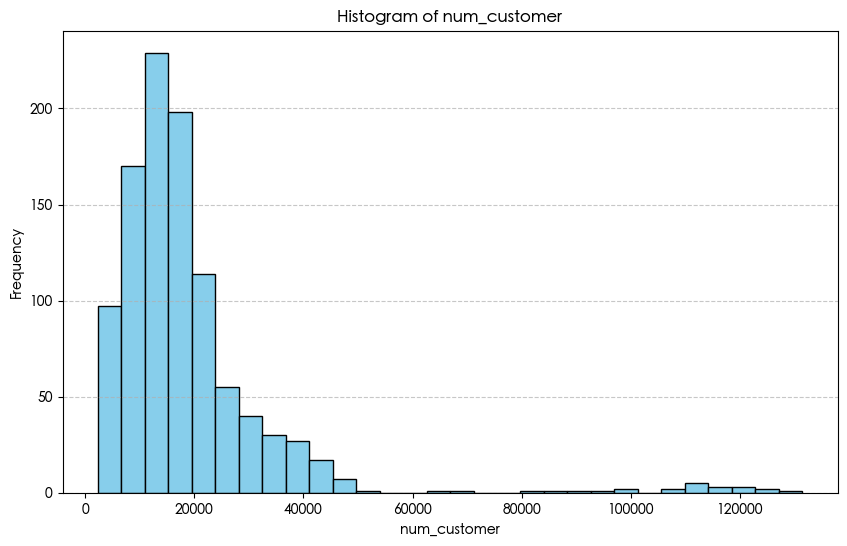

In [23]:
plot_data = info_coord_month_shift['mean_price'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(plot_data, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of num_customer')
plt.xlabel('num_customer')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 得分估計

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the models with specific parameters
models = {
    'Linear Regression': LinearRegression(),
    'Linear Regression (standardize)': make_pipeline(StandardScaler(), LinearRegression()),
    'Random Forest': RandomForestRegressor(), # n_estimators=100, max_features=10
    'XGBoost': XGBRegressor(),
}

In [262]:
info_coord_month.columns

Index(['addr_city', 'addr_district', 'addr_village', 'lat', 'lon', 'num_mark',
       'num_competitor', 'mean_competitor_distance', 'yyymm', 'yyyy-mm',
       'yyyy-m', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標',
       'sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax',
       'blur_restaurant_uuid', 'sum_customer', 'num_operate', 'mean_customer',
       'sum_customer_minmax', 'mean_customer_minmax'],
      dtype='object')

In [272]:
def fit_model(X,y,col_name):
    # Create a scorer (e.g., mean squared error for regression)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    mes = []
    model_n = []
    results_df = pd.DataFrame()
    # Perform cross-validation for each model
    for name, model in models.items():
        # Use KFold for splitting the data
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        
        # Print the results
        model_n.append(name)
        mes.append(abs(scores.mean()))

    results_df['model_name'] = model_n
    results_df[col_name] = mes
    return results_df.sort_values(by=[col_name])

## 本月資訊對本月銷售

In [147]:
# 全部不分月份 price

# Define predictor and response variables
# X = info_coord[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']].astype(float)
# y = info_coord['price']

# # Create a scorer (e.g., mean squared error for regression)
# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# mes = []
# model_n = []
# results_df = pd.DataFrame()
# # Perform cross-validation for each model
# for name, model in models.items():
#     # Use KFold for splitting the data
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
#     # Perform cross-validation
#     scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)
    
#     # Print the results
#     model_n.append(name)
#     mes.append(abs(scores.mean()))

# results_df['model_name'] = model_n
# results_df['MSE'] = mes
# results_df.sort_values(by=['MSE'])

,model_name,MSE
2,Random Forest,2.416072e+14
1,Linear Regression (standardize),2.848917e+14
0,Linear Regression,2.848917e+14
3,XGBoost,3.694222e+14


In [ ]:
# 全部不分月份 price(minmax)
# scaler = MinMaxScaler(feature_range=(0.01,0.99))
# X = info_coord.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']].astype(float)
# y = scaler.fit_transform(info_coord.dropna()['price'].values.reshape(-1, 1))
# fit_model(X,y)

In [265]:
# 分月份 dropna sum_price
X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09']['sum_price']
fit_model(X,y)

/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/3110799720.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/3110799720.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09']['sum_price']


,model_name,MSE
2,Random Forest,8.550658e+09
3,XGBoost,1.404457e+10
0,Linear Regression,1.697735e+11
1,Linear Regression (standardize),1.697735e+11


In [267]:
# 分月份 dropna sum_price_minmax
X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09']['sum_price_minmax']
fit_model(X,y)

/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/2121159346.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/2121159346.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09']['sum_price_minmax']


,model_name,MSE
2,Random Forest,12.645143
3,XGBoost,20.247809
0,Linear Regression,179.400615
1,Linear Regression (standardize),179.400615


In [273]:
# 分月份 dropna 一起跑！！！
checks = ['sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax', 
         'sum_customer', 'mean_customer', 'sum_customer_minmax', 'mean_customer_minmax']

check_result = pd.DataFrame()
for check in checks:
    X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
    y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09'][check]
    check_result = pd.concat([check_result, fit_model(X,y,check)], axis=1)

check_result # mean_price_minmax w RF

/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/826076373.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/826076373.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = info_coord_month.dropna()[info_coord_month['yyyy-mm']!='2023-09'][check]
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw0000gn/T/ipykernel_14706/826076373.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = info_coord_month.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
/var/folders/tz/nz01q07x0plcwl8kymj0g1yw00

,model_name,sum_price,model_name,mean_price,model_name,sum_price_minmax,model_name,mean_price_minmax,model_name,sum_customer,model_name,mean_customer,model_name,sum_customer_minmax,model_name,mean_customer_minmax
2,Random Forest,8.643680e+09,Random Forest,8.269092e+06,Random Forest,13.028734,Random Forest,11.027982,Random Forest,1.942582e+05,Random Forest,185.379437,Random Forest,36.017193,Random Forest,37.962967
3,XGBoost,1.404457e+10,XGBoost,1.120151e+07,XGBoost,20.247809,XGBoost,17.406545,XGBoost,2.032791e+05,XGBoost,192.491239,XGBoost,39.731289,XGBoost,36.839582
0,Linear Regression,1.697735e+11,Linear Regression,1.895658e+08,Linear Regression,179.400615,Linear Regression,182.991276,Linear Regression,2.004378e+06,Linear Regression,2306.661180,Linear Regression,339.470250,Linear Regression,349.331329
1,Linear Regression (standardize),1.697735e+11,Linear Regression (standardize),1.895658e+08,Linear Regression (standardize),179.400615,Linear Regression (standardize),182.991276,Linear Regression (standardize),2.004378e+06,Linear Regression (standardize),2306.661180,Linear Regression (standardize),339.470250,Linear Regression (standardize),349.331329


## 前月資訊對本月銷售(加入外帶、時間)

In [115]:
info_coord_month = pd.read_pickle('info_coord_month_new.pkl')
info_coord_month.columns

Index(['addr_city', 'addr_district', 'addr_village', 'lat', 'lon', 'num_mark',
       'num_competitor', 'mean_competitor_distance', 'yyymm', 'yyyy-mm',
       'yyyy-m', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標',
       'sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax',
       'blur_restaurant_uuid', 'sum_customer', 'num_operate', 'mean_customer',
       'sum_customer_minmax', 'mean_customer_minmax'],
      dtype='object')

In [275]:
[1,2,3,4][1:]

[2, 3, 4]

In [116]:
res_self = pd.read_pickle('addr_city_info.pkl')
res_self.rename(columns={'month-year':'yyyy-mm'}, inplace=True)
ym = ['2021-' + f'{m+1:02}' for m in range(6,12)] + ['2022-' + f'{m+1:02}' for m in range(12)] + ['2023-' + f'{m+1:02}' for m in range(9)]
res_self = res_self[res_self['yyyy-mm'].isin(ym)]
res_self['addr_city'] = res_self['addr_city'].apply(lambda x: re.sub('台','臺',x))
print(res_self.shape)
res_self.head(3)

(162, 5)


customer_group_service_type,yyyy-mm,delivery,indoor,takeout,addr_city
3,2021-07,292,0,5738,高雄市
4,2021-08,248,1425,5214,高雄市
5,2021-09,133,3632,4625,高雄市


In [117]:
info_coord_month = info_coord_month.merge(res_self, how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 31)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,mean_price_minmax,blur_restaurant_uuid,sum_customer,num_operate,mean_customer,sum_customer_minmax,mean_customer_minmax,delivery,indoor,takeout
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,11.677614,r71ee64,1442,31,46.516129,27.745928,24.239224,16405,6338,63271
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,9.970858,rec62b3,1505,27,55.740741,29.182410,31.048197,16405,6338,63271
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,35.821545,rfa1ab3,1520,23,66.086957,29.524430,38.685061,16405,6338,63271


In [118]:
invoice_info = pd.read_pickle('invoice_info.pkl')
invoice_info.rename(columns={'yymm':'yyyy-mm', 'delivery':'delivery_tdiff', 'indoor':'indoor_tdiff', 'takeout':'takeout_tdiff'}, inplace=True)
ym = ['2021-' + f'{m+1:02}' for m in range(6,12)] + ['2022-' + f'{m+1:02}' for m in range(12)] + ['2023-' + f'{m+1:02}' for m in range(9)]
invoice_info = invoice_info[invoice_info['yyyy-mm'].isin(ym)]
print(invoice_info.shape)
invoice_info.head(3)

(1080, 5)


customer_group_service_type,blur_restaurant_uuid,yyyy-mm,delivery_tdiff,indoor_tdiff,takeout_tdiff
1,r3588c2,2021-07,0.0,0.0,1761.517551
2,r3588c2,2021-08,0.0,0.0,1143.060531
3,r3588c2,2021-09,0.0,0.0,844.849017


In [119]:
info_coord_month = info_coord_month.merge(invoice_info, how='left')
print(info_coord_month.shape)
info_coord_month.head(3)

(1080, 34)


,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,yyymm,yyyy-mm,...,num_operate,mean_customer,sum_customer_minmax,mean_customer_minmax,delivery,indoor,takeout,delivery_tdiff,indoor_tdiff,takeout_tdiff
0,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,11007,2021-07,...,31,46.516129,27.745928,24.239224,16405,6338,63271,4615.758617,3761.063846,701.852644
1,臺中市,北區,五常里,24.154454,120.681675,35,2,264.608801,11007,2021-07,...,27,55.740741,29.182410,31.048197,16405,6338,63271,4345.453292,1892.883333,468.708979
2,臺中市,北屯區,北京里,24.162347,120.692539,50,0,0.000000,11007,2021-07,...,23,66.086957,29.524430,38.685061,16405,6338,63271,566.008873,0.000000,1144.738723


In [120]:
info_coord_month.columns

Index(['addr_city', 'addr_district', 'addr_village', 'lat', 'lon', 'num_mark',
       'num_competitor', 'mean_competitor_distance', 'yyymm', 'yyyy-mm',
       'yyyy-m', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標',
       'sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax',
       'blur_restaurant_uuid', 'sum_customer', 'num_operate', 'mean_customer',
       'sum_customer_minmax', 'mean_customer_minmax', 'delivery', 'indoor',
       'takeout', 'delivery_tdiff', 'indoor_tdiff', 'takeout_tdiff'],
      dtype='object')

In [121]:
# 平移 shift
info_coord_month = info_coord_month.dropna()
info_coord_month_shift = pd.DataFrame()
for res in info_coord_month['blur_restaurant_uuid'].drop_duplicates().tolist():
    temp = info_coord_month[info_coord_month['blur_restaurant_uuid']==res].sort_values(by=['yyyy-mm'])
    len_temp = len(temp)
    pre = temp[['blur_restaurant_uuid', 'addr_city', 'addr_district', 'addr_village', 'lat', 'lon', 'num_mark',
                'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標',
                'delivery', 'indoor','takeout','delivery_tdiff', 'indoor_tdiff', 'takeout_tdiff']].iloc[:(len_temp-1),:]
    pre.reset_index(inplace=True)
    now = temp[['sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax', 'sum_customer', 'mean_customer', 
                'sum_customer_minmax', 'mean_customer_minmax', 'yyymm', 'yyyy-mm', 'yyyy-m']].iloc[1:,:]
    now.reset_index(inplace=True)
    info_coord_month_shift = pd.concat([info_coord_month_shift, pd.concat([pre,now], axis=1)], axis=0)

print(info_coord_month_shift.shape)
info_coord_month_shift.head(3)

(1009, 35)


,index,blur_restaurant_uuid,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,...,mean_price,sum_price_minmax,mean_price_minmax,sum_customer,mean_customer,sum_customer_minmax,mean_customer_minmax,yyymm,yyyy-mm,yyyy-m
0,0,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,10223.064516,14.140998,13.597906,2196,70.838710,33.463908,33.463908,11008,2021-08,2021-8
1,40,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,12137.115385,13.665286,15.568064,2433,93.576923,35.725612,42.627285,11009,2021-09,2021-9
2,80,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,14527.516129,15.675867,15.298859,3525,113.709677,38.649394,37.097719,11010,2021-10,2021-10


In [123]:
info_coord_month_shift.to_pickle('info_coord_month_new_shift.pkl')
info_coord_month.to_pickle('info_coord_month_new.pkl')

In [227]:
# info_coord_month.to_csv('info_coord_month_new.csv')
# info_coord_month_shift.to_csv('info_coord_month_new_shift.csv')

In [279]:
# 分月份 dropna 一起跑！！！
checks = ['sum_price', 'mean_price', 'sum_price_minmax', 'mean_price_minmax', 
         'sum_customer', 'mean_customer', 'sum_customer_minmax', 'mean_customer_minmax']

check_result = pd.DataFrame()
for check in checks:
    X = info_coord_month_shift.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month_shift['yyyy-mm']!='2023-09'].astype(float)
    y = info_coord_month_shift.dropna()[info_coord_month_shift['yyyy-mm']!='2023-09'][check]
    check_result = pd.concat([check_result, fit_model(X,y,check)], axis=1)

check_result # mean_price_minmax w RF

,model_name,sum_price,model_name,mean_price,model_name,sum_price_minmax,model_name,mean_price_minmax,model_name,sum_customer,model_name,mean_customer,model_name,sum_customer_minmax,model_name,mean_customer_minmax
2,Random Forest,9.978422e+09,Random Forest,8.402065e+06,Random Forest,10.151956,Random Forest,8.060291,Random Forest,1.977508e+05,Random Forest,181.053546,Random Forest,30.178106,Random Forest,32.379666
3,XGBoost,1.513177e+10,XGBoost,1.281108e+07,XGBoost,9.559527,XGBoost,8.733762,XGBoost,2.358073e+05,XGBoost,204.854585,XGBoost,32.151748,XGBoost,31.533700
0,Linear Regression,1.745005e+11,Linear Regression,1.941805e+08,Linear Regression,174.327658,Linear Regression,177.539798,Linear Regression,2.013453e+06,Linear Regression,2312.966525,Linear Regression,323.080054,Linear Regression,331.476549
1,Linear Regression (standardize),1.745005e+11,Linear Regression (standardize),1.941805e+08,Linear Regression (standardize),174.327658,Linear Regression (standardize),177.539798,Linear Regression (standardize),2.013453e+06,Linear Regression (standardize),2312.966525,Linear Regression (standardize),323.080054,Linear Regression (standardize),331.476549


## 預測2023-09效果

### 本月資訊對本月銷售

In [308]:
# 本月資訊對本月銷售
X = info_coord_month[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']!='2023-09'].astype(float)
y = info_coord_month[info_coord_month['yyyy-mm']!='2023-09']['mean_price_minmax']

X_test = info_coord_month[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month['yyyy-mm']=='2023-09'].astype(float)
y_test = np.array(info_coord_month[info_coord_month['yyyy-mm']=='2023-09']['mean_price_minmax'])

model = RandomForestRegressor(random_state=2023)
model.fit(X,y)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

14.179064901999581

In [309]:
stats.spearmanr(y_test, y_pred).statistic

0.9662288930581614

In [310]:
result = info_coord_month[info_coord_month['yyyy-mm']=='2023-09'][['blur_restaurant_uuid','addr_city', 'addr_district', 'addr_village']]
result['true_score'] = y_test
result['predict_score'] = y_pred
result['true_score_rank'] = result['true_score'].rank(ascending=False)
result['predict_score_rank'] = result['predict_score'].rank(ascending=False)
result.sort_values(by=['predict_score_rank'])

,blur_restaurant_uuid,addr_city,addr_district,addr_village,true_score,predict_score,true_score_rank,predict_score_rank
1050,rbe4009,臺中市,西屯區,惠來里,99.000000,99.000000,1.0,1.0
1044,r3d1075,臺中市,南屯區,大業里,36.849699,39.996100,3.0,2.0
1065,r9ae7da,新北市,板橋區,文化里,29.281097,32.101674,5.0,3.0
1066,rf767b1,新北市,板橋區,漢生里,31.790141,31.197739,4.0,4.0
1046,r9c6dd9,臺中市,大里區,新里里,23.602881,28.999192,7.0,5.0
1043,r4ea226,臺中市,南區,福平里,23.086092,27.772954,8.0,6.0
1055,re923de,臺北市,大安區,錦華里,25.610724,24.301463,6.0,7.0
1077,r80e8d4,高雄市,三民區,鼎泰里,18.837625,20.560749,11.0,8.0
1056,r91c411,臺北市,大安區,誠安里,18.936950,19.320727,10.0,9.0
1053,rc0b601,臺北市,士林區,德行里,15.798297,18.302929,13.0,10.0


### 前月資訊對本月銷售

In [6]:
# 前月資訊對本月銷售data
info_coord_month_shift = pd.read_pickle('info_coord_month_new_shift.pkl')
info_coord_month_shift.head(3)

,index,blur_restaurant_uuid,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,...,mean_price,sum_price_minmax,mean_price_minmax,sum_customer,mean_customer,sum_customer_minmax,mean_customer_minmax,yyymm,yyyy-mm,yyyy-m
0,0,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,10223.064516,14.140998,13.597906,2196,70.838710,33.463908,33.463908,11008,2021-08,2021-8
1,40,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,12137.115385,13.665286,15.568064,2433,93.576923,35.725612,42.627285,11009,2021-09,2021-9
2,80,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,14527.516129,15.675867,15.298859,3525,113.709677,38.649394,37.097719,11010,2021-10,2021-10


In [26]:
# 前月資訊對本月銷售
X = info_coord_month_shift[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month_shift['yyyy-mm']!='2023-09'].astype(float)
y = info_coord_month_shift[info_coord_month_shift['yyyy-mm']!='2023-09']['mean_price_minmax']

X_test = info_coord_month_shift[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標']][info_coord_month_shift['yyyy-mm']=='2023-09'].astype(float)
y_test = info_coord_month_shift[info_coord_month_shift['yyyy-mm']=='2023-09']['mean_price_minmax']

model = RandomForestRegressor(random_state=2023)
model.fit(X,y)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

10.698867125098747

In [27]:
stats.spearmanr(y_test, y_pred).statistic

0.9696060037523453

In [28]:
pipe = Pipeline([
    ('model',model)
])
pipe.fit(X,y)

print(pipe.score(X_test, y_test))
print('RMSE: {}'.format(mean_squared_error(y_test, pipe.predict(X_test),squared=False)))

0.9582639869846439
RMSE: 3.2709122771940473


In [29]:
variable_importance = {}
importance = model.feature_importances_
variable_importance['importance'] = dict(zip(X.columns, importance))
importance_df = pd.DataFrame(variable_importance).sort_values(by=['importance'], ascending=False)
importance_df

,importance
人口數,0.376151
密度,0.188448
戶數,0.129766
num_competitor,0.101821
num_mark,0.086515
mean_competitor_distance,0.057624
消費力,0.044244
ave_temp,0.007670
acc_rain,0.006399
豪雨指標,0.001362


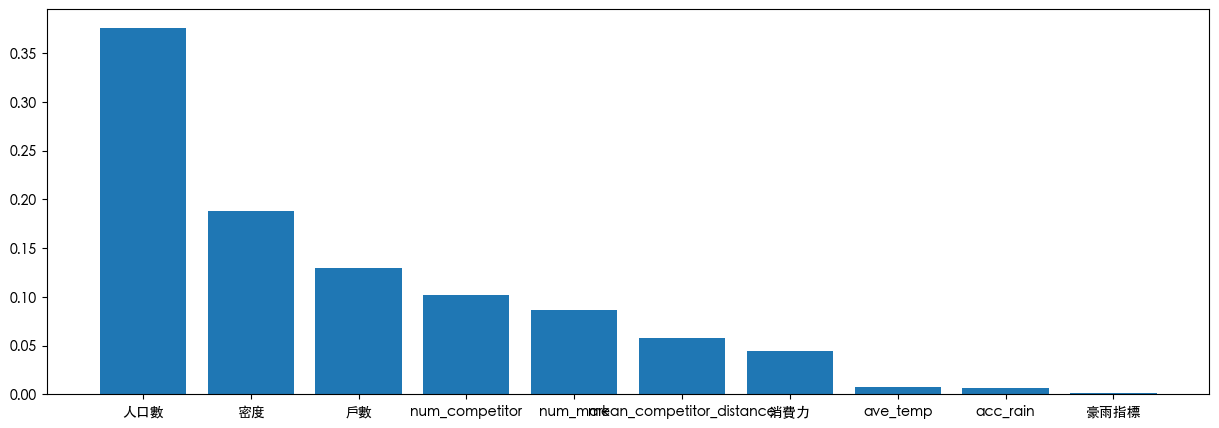

In [19]:
importance_df = importance_df.sort_values(by=["importance"], ascending=False)
# 設定字型
matplotlib.rcParams['font.family'] = "HeiTi TC"
# Figure Size
fig = plt.figure(figsize =(15, 5))
# Horizontal Bar Plot
plt.bar(importance_df.index[0:15], importance_df["importance"][0:15])
# plt.ylim(0,0.05)
# Show Plot
plt.show()

In [20]:
result = info_coord_month_shift[info_coord_month_shift['yyyy-mm']=='2023-09'][['blur_restaurant_uuid','addr_city', 'addr_district', 'addr_village']]
result['true_score'] = y_test
result['predict_score'] = y_pred
result['true_score_rank'] = result['true_score'].rank(ascending=False)
result['predict_score_rank'] = result['predict_score'].rank(ascending=False)
result.sort_values(by=['predict_score_rank'])

,blur_restaurant_uuid,addr_city,addr_district,addr_village,true_score,predict_score,true_score_rank,predict_score_rank
23,rbe4009,臺中市,西屯區,惠來里,99.000000,99.000000,1.0,1.0
24,r3d1075,臺中市,南屯區,大業里,36.849699,39.487049,3.0,2.0
24,rf767b1,新北市,板橋區,漢生里,31.790141,38.170808,4.0,3.0
24,r9ae7da,新北市,板橋區,文化里,29.281097,34.643016,5.0,4.0
24,r9c6dd9,臺中市,大里區,新里里,23.602881,29.352976,7.0,5.0
24,r4ea226,臺中市,南區,福平里,23.086092,28.860660,8.0,6.0
24,rda94f6,臺北市,松山區,東光里,38.087609,25.883209,2.0,7.0
24,re923de,臺北市,大安區,錦華里,25.610724,23.792445,6.0,8.0
25,r80e8d4,高雄市,三民區,鼎泰里,18.837625,21.038695,11.0,9.0
24,r91c411,臺北市,大安區,誠安里,18.936950,20.681864,10.0,10.0


### 加入店家資料

In [124]:
# 前月資訊對本月銷售data
info_coord_month_shift = pd.read_pickle('info_coord_month_new_shift.pkl')
print(info_coord_month_shift.shape)
info_coord_month_shift.head(3)

(1009, 35)


,index,blur_restaurant_uuid,addr_city,addr_district,addr_village,lat,lon,num_mark,num_competitor,mean_competitor_distance,...,mean_price,sum_price_minmax,mean_price_minmax,sum_customer,mean_customer,sum_customer_minmax,mean_customer_minmax,yyymm,yyyy-mm,yyyy-m
0,0,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,10223.064516,14.140998,13.597906,2196,70.838710,33.463908,33.463908,11008,2021-08,2021-8
1,40,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,12137.115385,13.665286,15.568064,2433,93.576923,35.725612,42.627285,11009,2021-09,2021-9
2,80,r71ee64,臺中市,北區,賴旺里,24.172038,120.673495,47,2,296.223296,...,14527.516129,15.675867,15.298859,3525,113.709677,38.649394,37.097719,11010,2021-10,2021-10


In [125]:
info_coord_month_shift.columns

Index(['index', 'blur_restaurant_uuid', 'addr_city', 'addr_district',
       'addr_village', 'lat', 'lon', 'num_mark', 'num_competitor',
       'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp',
       'acc_rain', '豪雨指標', 'delivery', 'indoor', 'takeout', 'delivery_tdiff',
       'indoor_tdiff', 'takeout_tdiff', 'index', 'sum_price', 'mean_price',
       'sum_price_minmax', 'mean_price_minmax', 'sum_customer',
       'mean_customer', 'sum_customer_minmax', 'mean_customer_minmax', 'yyymm',
       'yyyy-mm', 'yyyy-m'],
      dtype='object')

In [126]:
# 前月資訊對本月銷售
X = info_coord_month_shift.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標','delivery','indoor','takeout','delivery_tdiff','indoor_tdiff','takeout_tdiff','lat','lon']][info_coord_month_shift['yyyy-mm']!='2023-09'].astype(float)
y = info_coord_month_shift.dropna()[info_coord_month_shift['yyyy-mm']!='2023-09']['mean_price_minmax']

X_test = info_coord_month_shift.dropna()[['num_mark', 'num_competitor', 'mean_competitor_distance', '戶數', '人口數', '密度', '消費力', 'ave_temp', 'acc_rain', '豪雨指標','delivery','indoor','takeout','delivery_tdiff','indoor_tdiff','takeout_tdiff','lat','lon']][info_coord_month_shift['yyyy-mm']=='2023-09'].astype(float)
y_test = info_coord_month_shift.dropna()[info_coord_month_shift['yyyy-mm']=='2023-09']['mean_price_minmax']

model = RandomForestRegressor(random_state=2023)
model.fit(X,y)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

7.908266565504164

In [127]:
stats.spearmanr(y_test, y_pred).statistic

0.9763602251407131

In [128]:
pipe = Pipeline([
    ('model',model)
])
pipe.fit(X,y)

print(pipe.score(X_test, y_test))
print('RMSE: {}'.format(mean_squared_error(y_test, pipe.predict(X_test),squared=False)))

0.969150049958795
RMSE: 2.8121640360235327


In [129]:
variable_importance = {}
importance = model.feature_importances_
variable_importance['importance'] = dict(zip(X.columns, importance))
importance_df = pd.DataFrame(variable_importance).sort_values(by=['importance'], ascending=False)
importance_df

,importance
人口數,0.337630
takeout_tdiff,0.080450
密度,0.076210
戶數,0.060711
delivery,0.060599
lat,0.055997
num_mark,0.054838
lon,0.054562
indoor,0.050104
takeout,0.036933


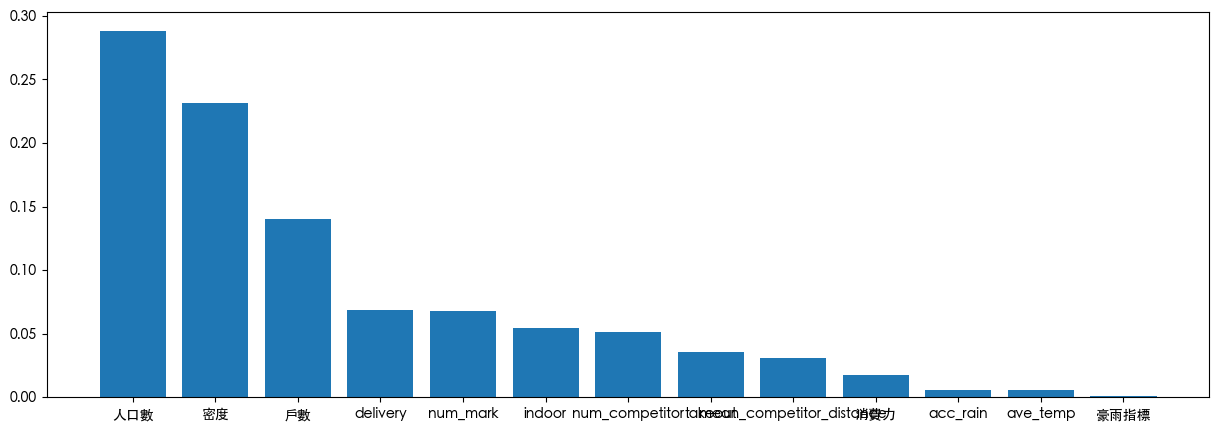

In [45]:
importance_df = importance_df.sort_values(by=["importance"], ascending=False)
# 設定字型
matplotlib.rcParams['font.family'] = "HeiTi TC"
# Figure Size
fig = plt.figure(figsize =(15, 5))
# Horizontal Bar Plot
plt.bar(importance_df.index[0:15], importance_df["importance"][0:15])
# plt.ylim(0,0.05)
# Show Plot
plt.show()